In [2]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
from subprocess import call

np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

In [4]:
# Dnase
# A549 GM12878 H1-hESC HeLA-S3 HepG2 K562 MCF-7 
# [52, 53, 54, 55, 56, 61, 63]

name = 'DeepSea' # 'DeepSea'
datapath = '/media/peter/storage/'+name
options = {"class_range":[52, 53, 54, 55, 56, 61, 63],'num_include':500000}
train, valid, test = load_data(name, datapath, options)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = np.round(train[1].shape[1])

loading training data
(500000, 4, 1000, 1)
loading validation data
(1498, 4, 1000, 1)
loading test data
(87724, 4, 1000, 1)


In [5]:
# build model
model_name = "genome_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [6]:
#nnmodel.print_layers()
# set output file paths
filename = model_name + "_new"
datapath = make_directory(datapath, 'Results')
filepath = os.path.join(datapath, filename)

# train model
batch_size = 100
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=batch_size, num_epochs=500, 
            patience=10, verbose=1, filepath=filepath)


Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.55039 -- accuracy=74.32%  
ROC
[ 0.69765917  0.62727044  0.77882153  0.66543564  0.72444468  0.58485627
  0.67421533]
PR
[ 0.47342735  0.36939277  0.55150956  0.45186672  0.46049725  0.33136103
  0.451126  ]
  valid loss:		0.55917
  valid accuracy:	0.74630+/-0.02087
  valid auc-roc:	0.67896+/-0.05870
  valid auc-pr:		0.44131+/-0.06656
saving model parameters to: /media/peter/storage/DeepSea/Results/genome_motif_model_new_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.50782 -- accuracy=75.98%  
ROC
[ 0.71671753  0.76564272  0.81224505  0.71658077  0.78247027  0.7432214
  0.72935944]
PR
[ 0.49718891  0.51872636  0.61330285  0.5044812   0.52920333  0.49718931
  0.50648382]
  valid loss:		0.50273
  valid accuracy:	0.76393+/-0.02072
  valid auc-roc:	0.75232+/-0.03345
  valid auc-pr:		0.52380+/-0.03809
saving model parameters to: /media/peter/storage/DeepSea/Resul

KeyboardInterrupt: 

In [ ]:

# save best model --> lowest cross-validation error
min_loss, min_index = nnmodel.get_min_loss()
savepath = filepath + "_epoch_" + str(min_index) + ".pickle"
nnmodel.set_parameters_from_file(savepath)
savepath = filepath + "_best.pickle"
nnmodel.save_model_parameters(savepath)

# test model
nnmodel.test_model(test, batch_size, "test")

In [7]:
net = nnmodel.network
net

{'conv1': <lasagne.layers.conv.Conv2DLayer at 0x7fd63a2fa490>,
 'conv1_2_1resid': <lasagne.layers.conv.Conv2DLayer at 0x7fd63a3416d0>,
 'conv1_2_1resid_active': <lasagne.layers.special.NonlinearityLayer at 0x7fd63a341cd0>,
 'conv1_2_1resid_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7fd63a341690>,
 'conv1_2_2resid': <lasagne.layers.conv.Conv2DLayer at 0x7fd63a341ed0>,
 'conv1_2_2resid_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7fd63a341e90>,
 'conv1_2_dropout': <lasagne.layers.noise.DropoutLayer at 0x7fd63a32b710>,
 'conv1_2_resid': <lasagne.layers.special.NonlinearityLayer at 0x7fd63a32b690>,
 'conv1_2_residual': <lasagne.layers.merge.ElemwiseSumLayer at 0x7fd63a32b510>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7fd63a341490>,
 'conv1_dropout1': <lasagne.layers.noise.DropoutLayer at 0x7fd63a341610>,
 'conv1_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7fd63a2fa450>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fd

In [8]:

def height_logo(X, I, height=100, nt_width=20, norm=0, rna=0, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # resize nucleotide images for each base of sequence and stack
    num_seq = X.shape[2]
    width = np.ceil(nt_width*num_seq).astype(int)    
    logo = np.ones((height, width, 3)).astype(int)*255;
    nt_height = np.round(height*I).astype(int)

    for i in range(num_seq):
        index = np.argmax(X[0,:,i,0])

        # resized dimensions of image
        if nt_height[i] > 0:
            resize = (nt_height[i], nt_width)
            if index == 0:
                nt_img = imresize(A_img, resize)
            elif index == 1:
                nt_img = imresize(C_img, resize)
            elif index == 2:
                nt_img = imresize(G_img, resize)
            elif index == 3:
                nt_img = imresize(T_img, resize)

            # determine location of image
            height_range = range(height-nt_height[i],height)
            width_range = range(i*nt_width, i*nt_width+nt_width)

            # 'annoying' way to broadcast resized nucleotide image
            if height_range:
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

    return logo.astype(np.uint8)

In [9]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=0, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
        T_img = df.as_matrix()
        T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, G_img, C_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [10]:
import theano
import theano.tensor as T
import lasagne
def compile_saliency_function(net):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(net['conv5_active'], deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

In [11]:
train_fn = compile_saliency_function(net)

In [12]:
class ModifiedBackprop(object):

    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
       
        cuda_var = theano.sandbox.cuda.as_cuda_ndarray_variable
        x = cuda_var(x)
        tensor_type = x.type
        
        if tensor_type not in self.ops:
            input_var = tensor_type()
            output_var = cuda_var(self.nonlinearity(input_var))
            op = theano.OpFromGraph([input_var], [output_var])
            op.grad = self.grad
            self.ops[tensor_type] = op

        return self.ops[tensor_type](x)
    
class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)



In [13]:
relu = nonlinearities.rectify
modified_relu = GuidedBackprop(relu)  # important: only instantiate this once!

relu_layers = [layer for layer in layers.get_all_layers(net['output'])
               if getattr(layer, 'nonlinearity', None) is relu]
for layer in relu_layers:
    layer.nonlinearity = modified_relu


In [14]:
saliency_fn = compile_saliency_function(net)

prediction = 2
prediction = 3


(-0.5, 5999.5, 199.5, -0.5)

/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


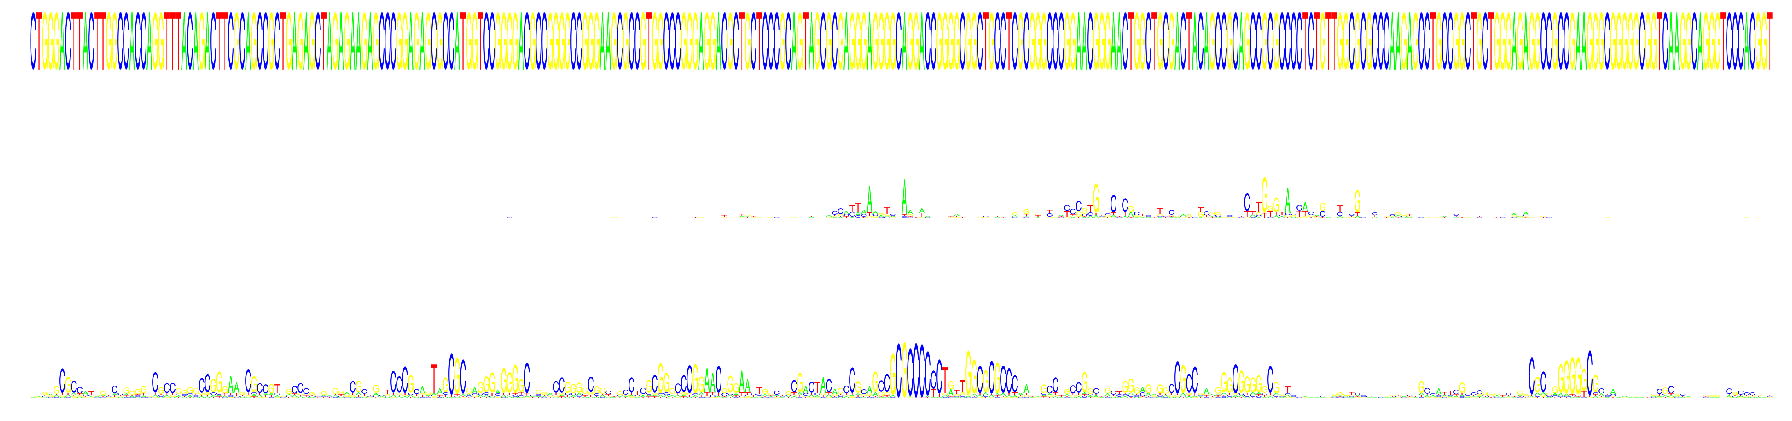

In [15]:
map_index = 7

X = test[0][map_index]
X = np.expand_dims(X,0).astype(np.float32)
y = test[1][map_index].astype(np.float32)

# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'prediction = ' + str(np.argmax(prediction))
print 'prediction = ' + str(np.argmax(y))


def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm


grad = train_fn(X)
saliency, max_class = saliency_fn(X)

height=100
bp_width=20
size = (25.,10.0)


pwm = np.copy(np.squeeze(grad[0]))
pwm=normalize_pwm2(pwm)
index = np.argmax(np.std(pwm,axis=0))
index = range(index-150,index+150)


logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(4,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


pwm = np.copy(np.squeeze(grad[0]))
pwm=normalize_pwm2(pwm)
index = np.argmax(np.std(pwm,axis=0))
index = range(index-150,index+150)
pwm = pwm[:,index]

plt.subplot(4,1,2)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');

pwm2 = np.copy(np.squeeze(saliency[0]))
pwm2=normalize_pwm2(pwm2)
index = np.argmax(np.std(pwm2,axis=0))
index = range(index-150,index+150)
pwm2 = pwm2[:,index]

plt.subplot(4,1,3)
logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


#pwm3=ImportanceDeconvolution(X,net)
#pwm3=normalize_pwm2(pwm3)

#plt.subplot(4,1,4)
#logo = seq_logo(pwm3, height, bp_width, norm=0, rna=0, filepath='.')
#plt.imshow(logo, interpolation='none');
#plt.axis('off');




# A549

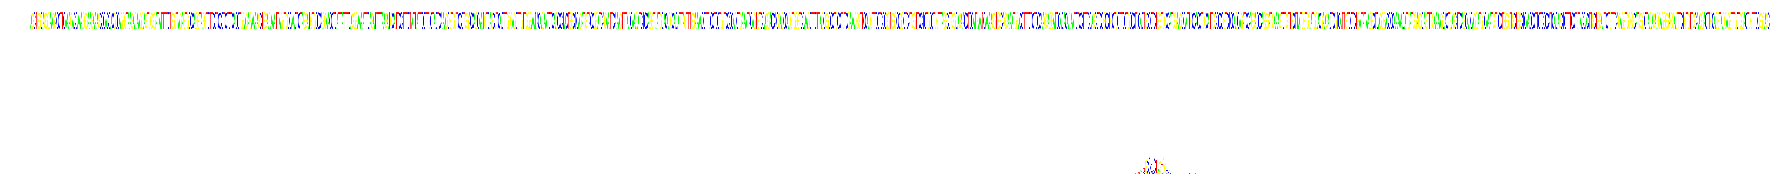

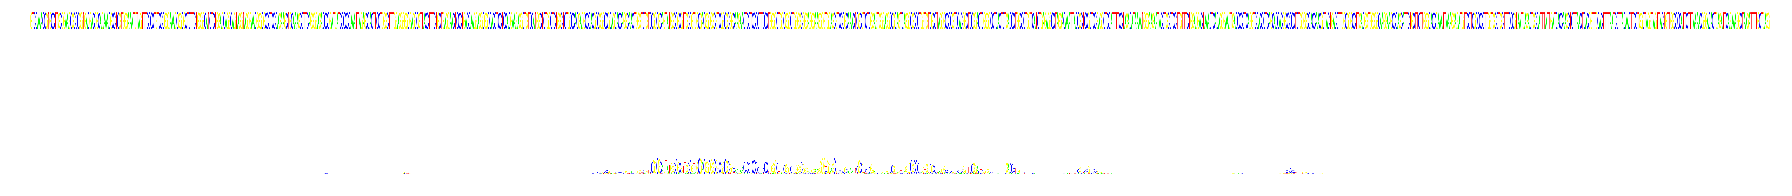

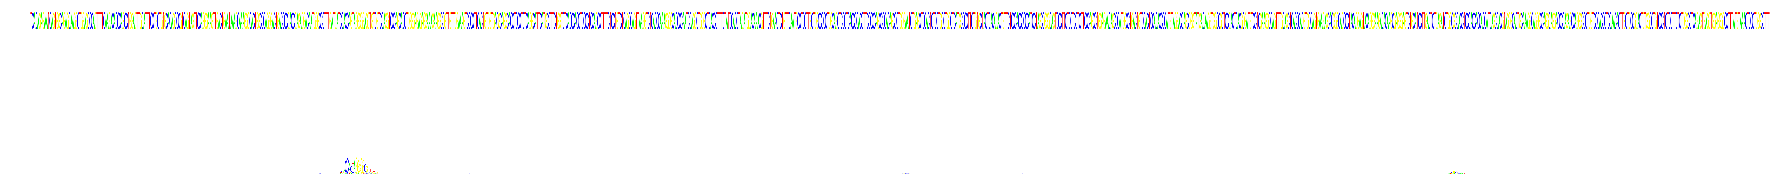

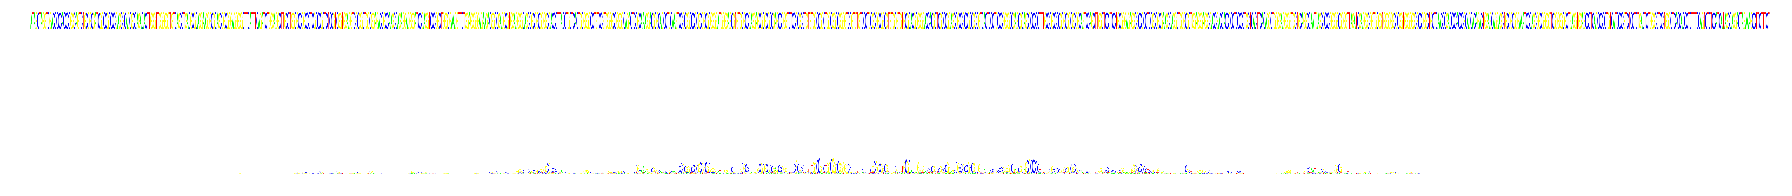

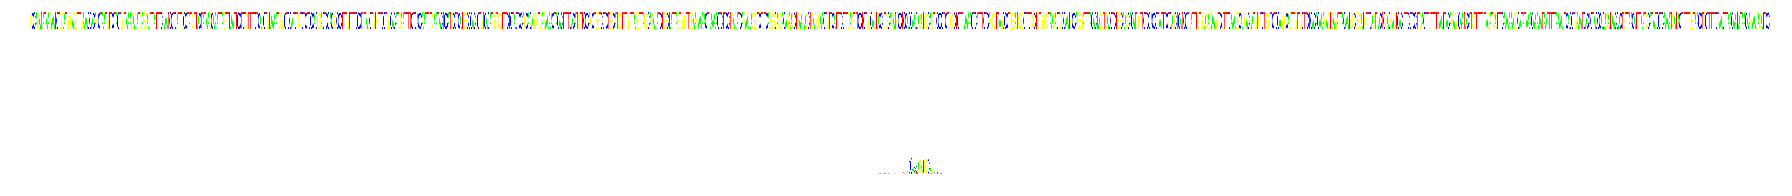

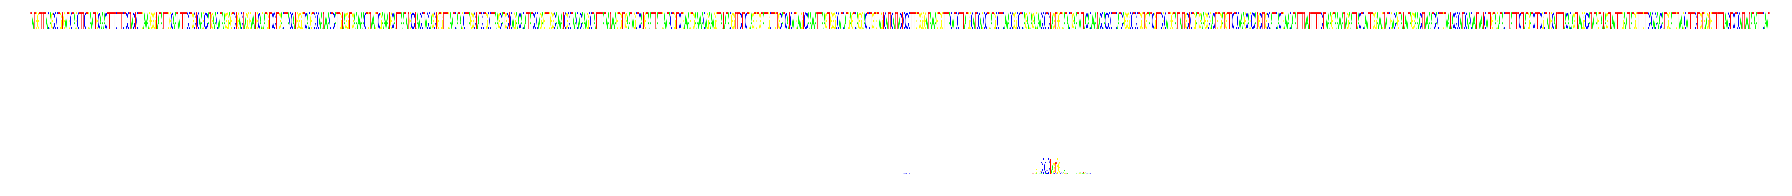

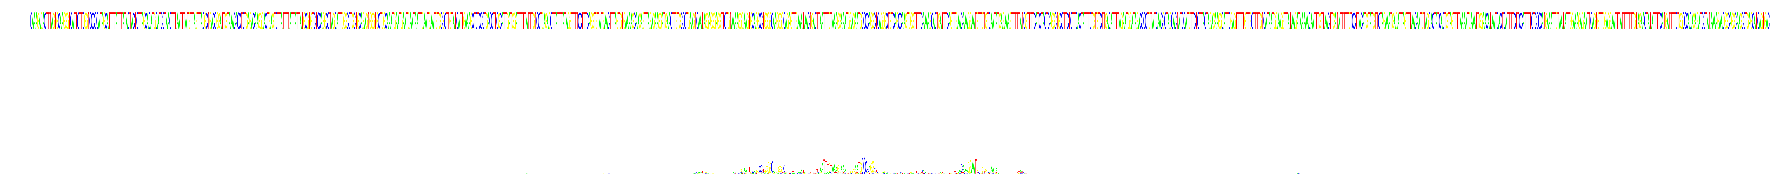

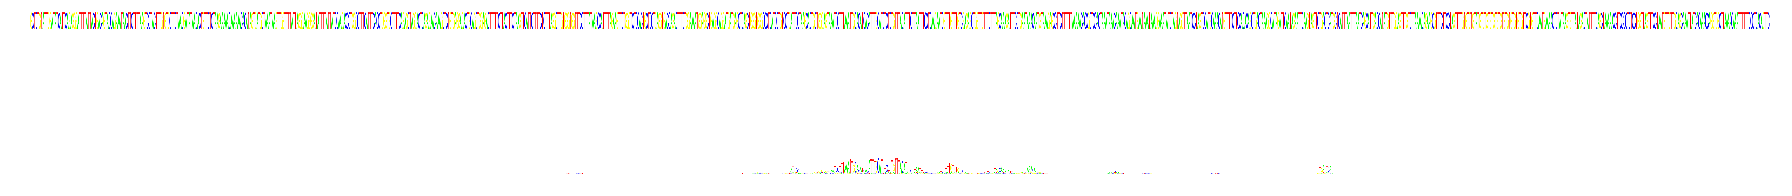

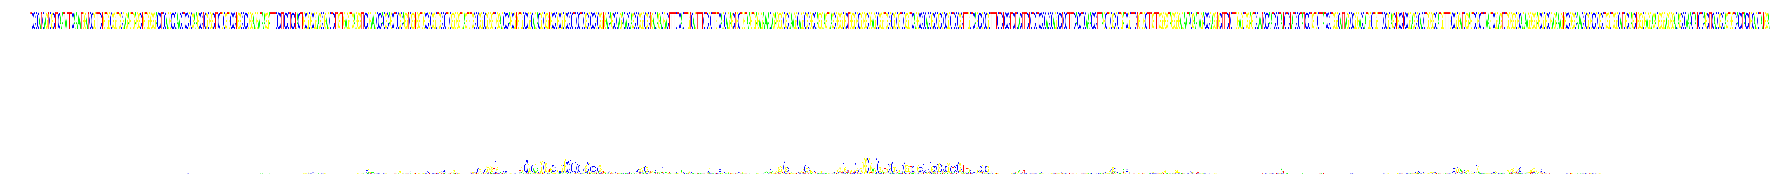

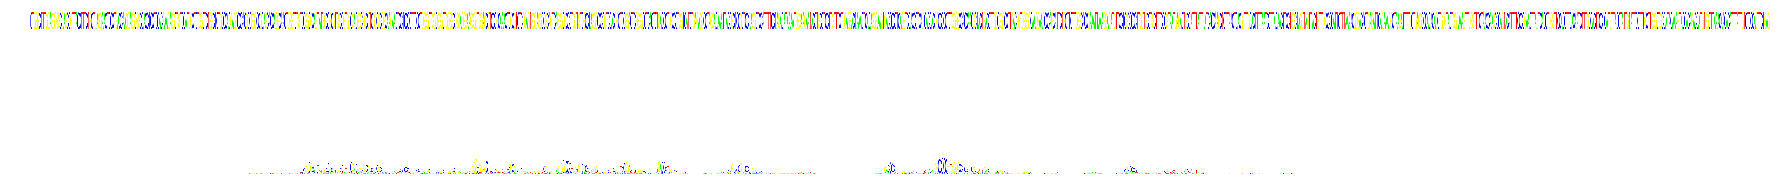

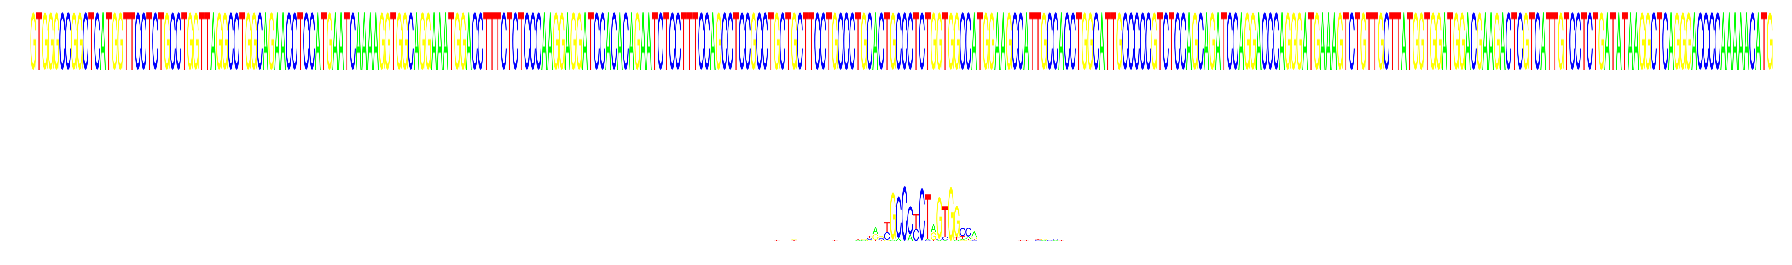

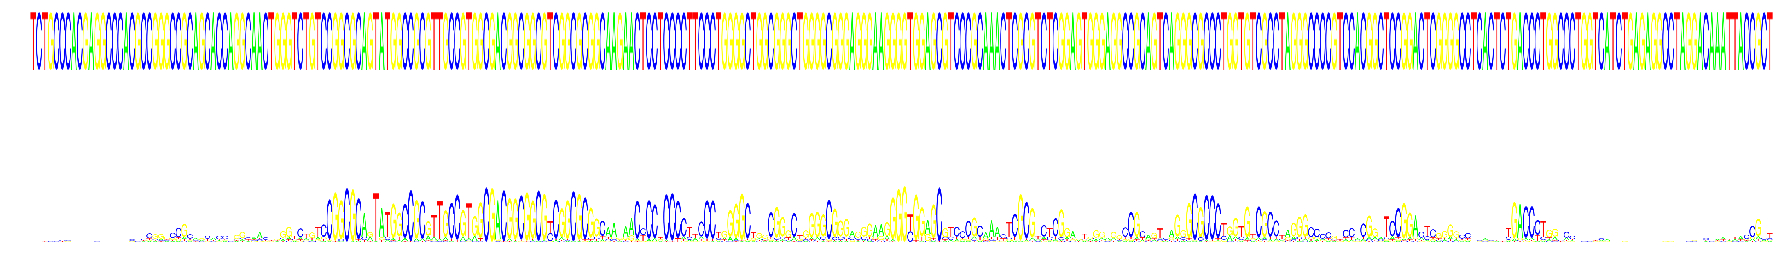

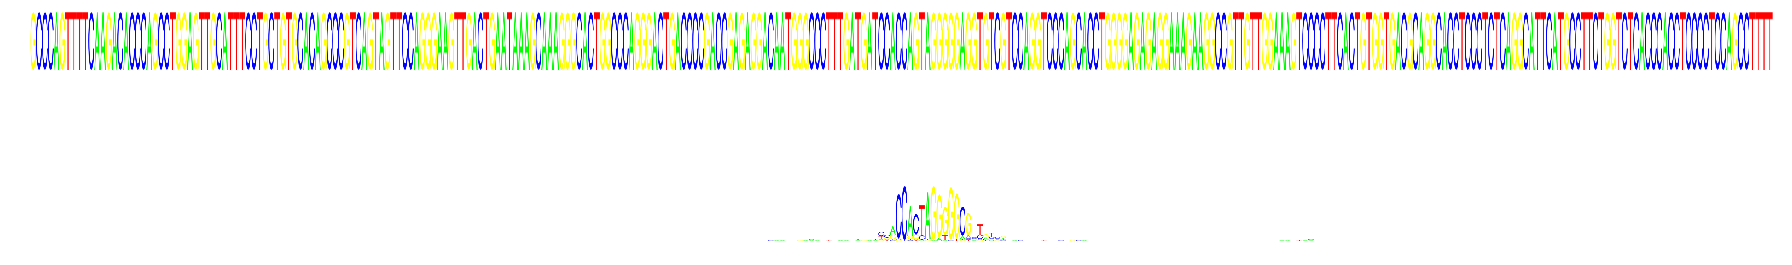

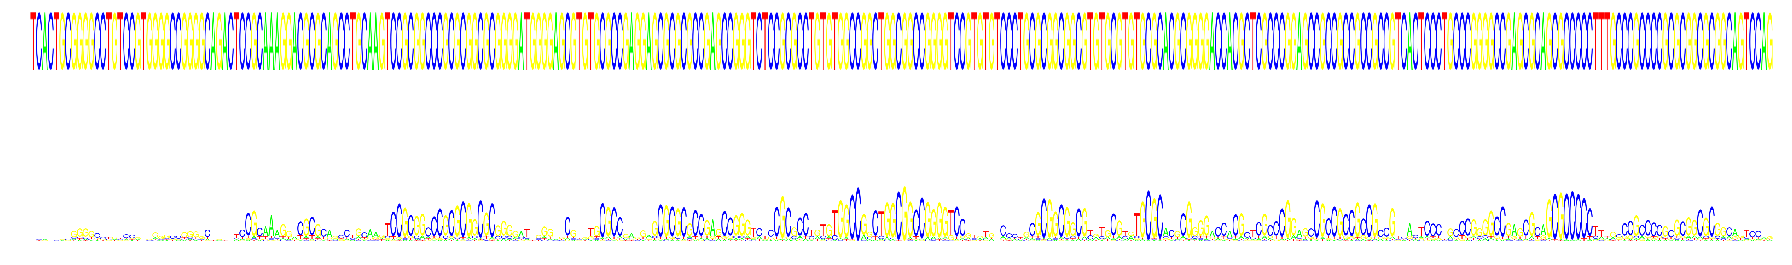

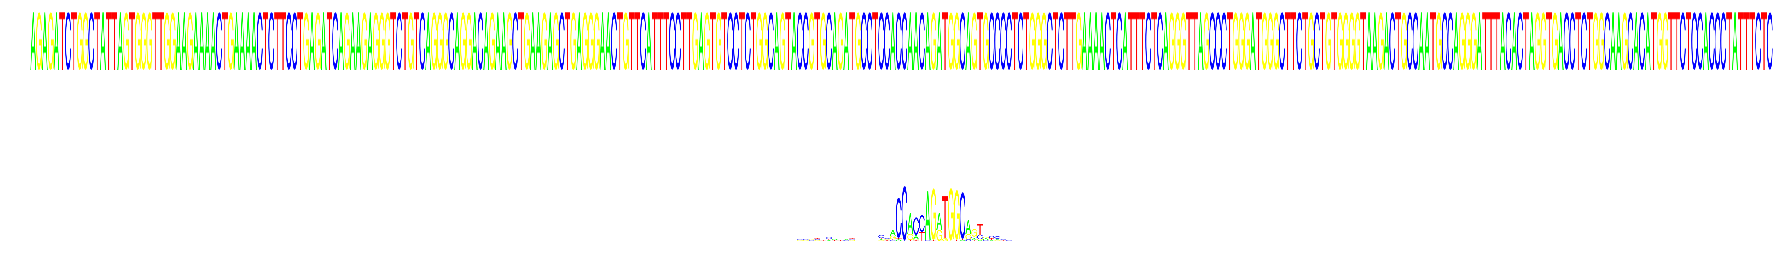

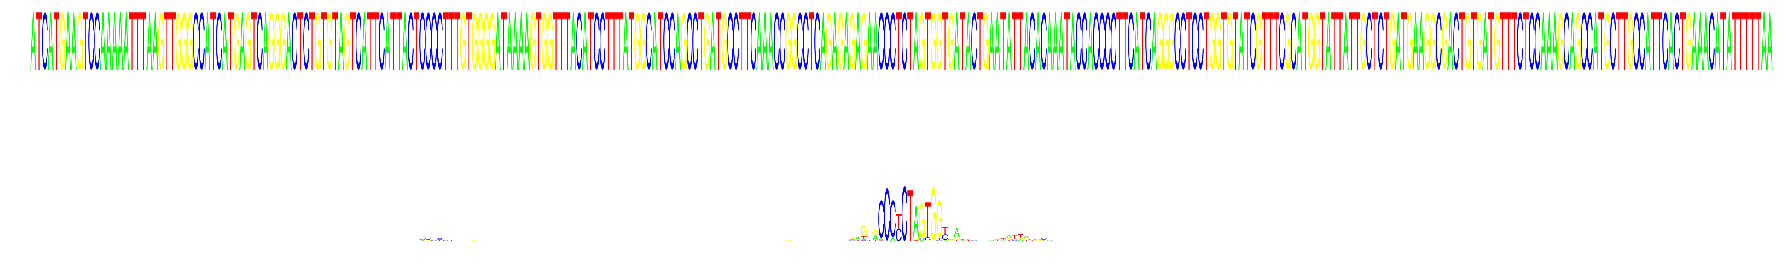

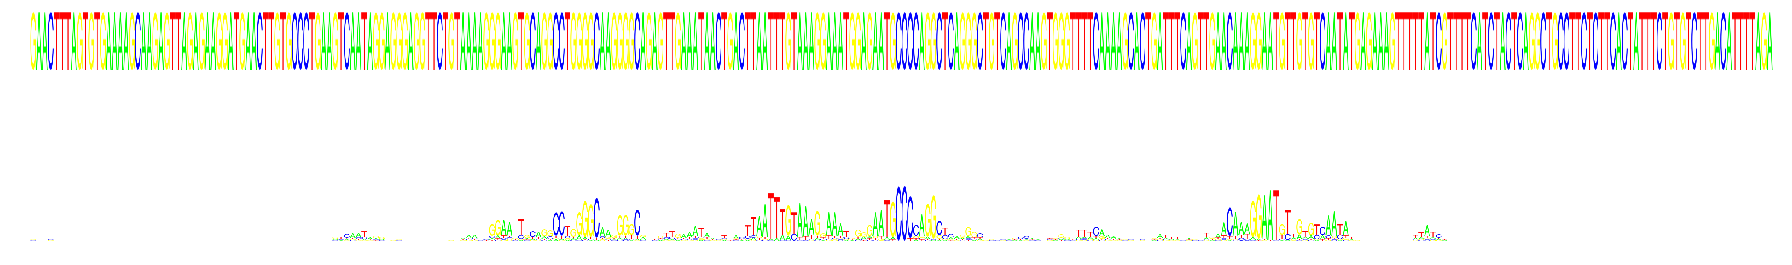

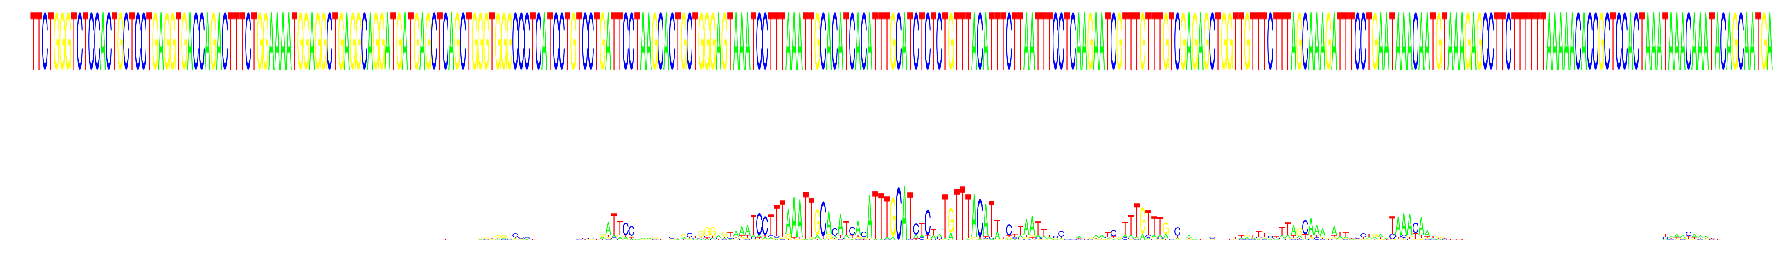

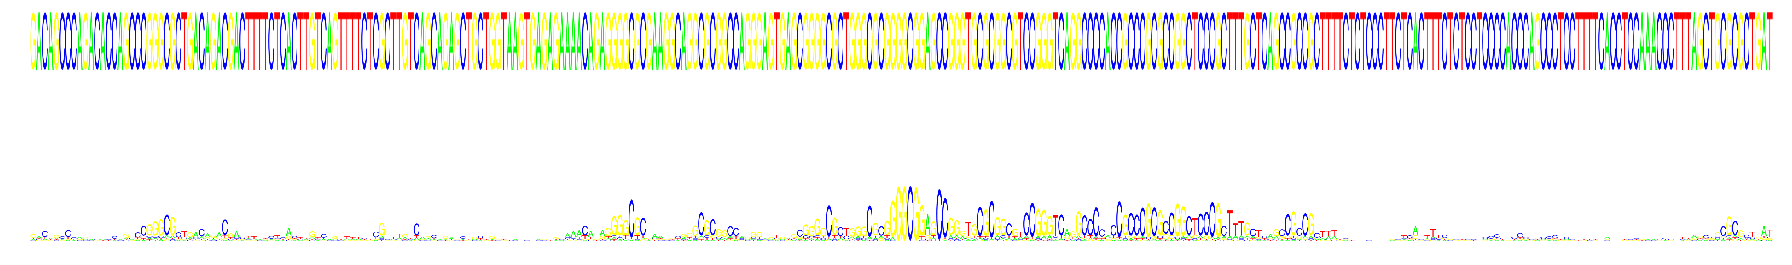

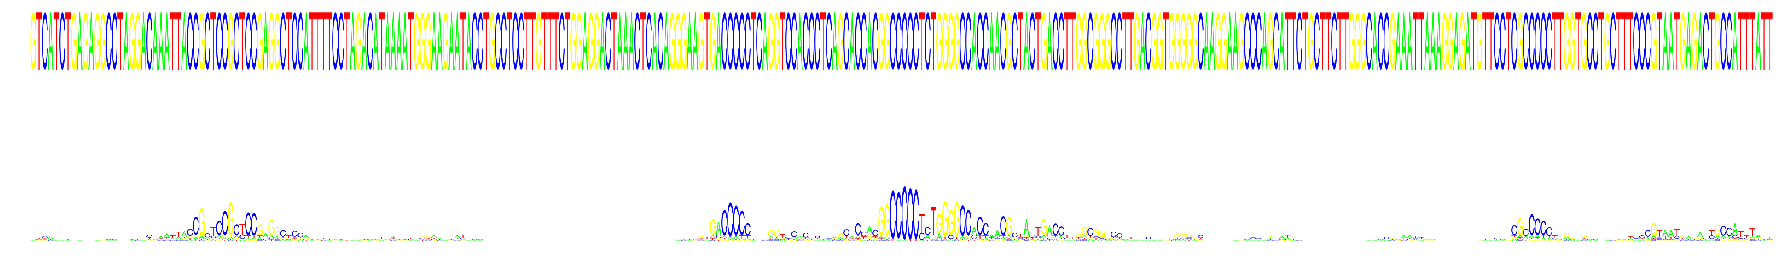

In [23]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,0]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


# GM12878

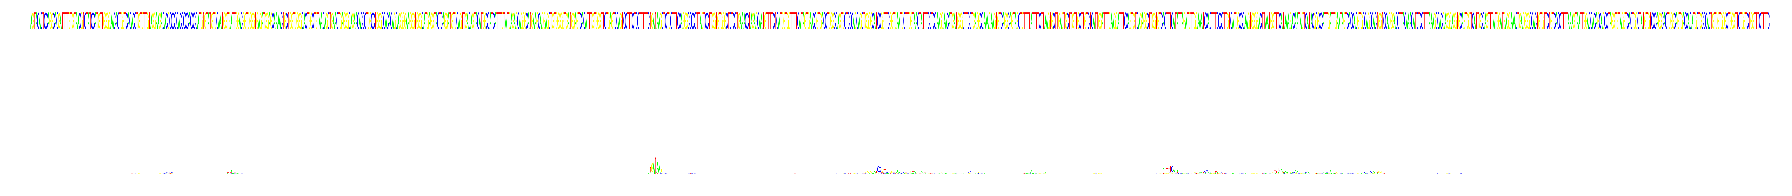

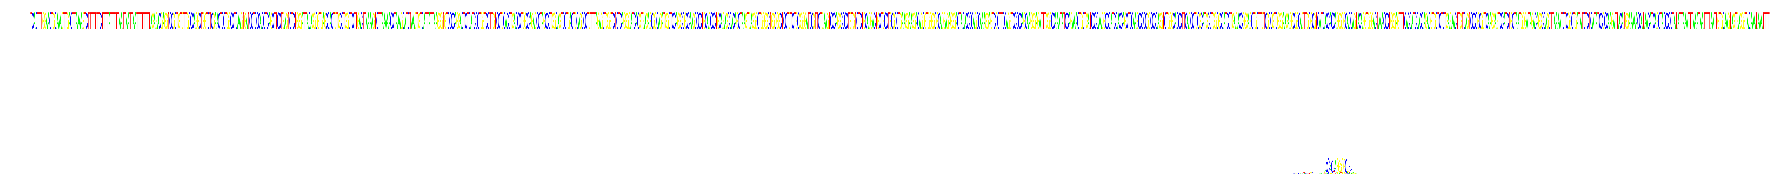

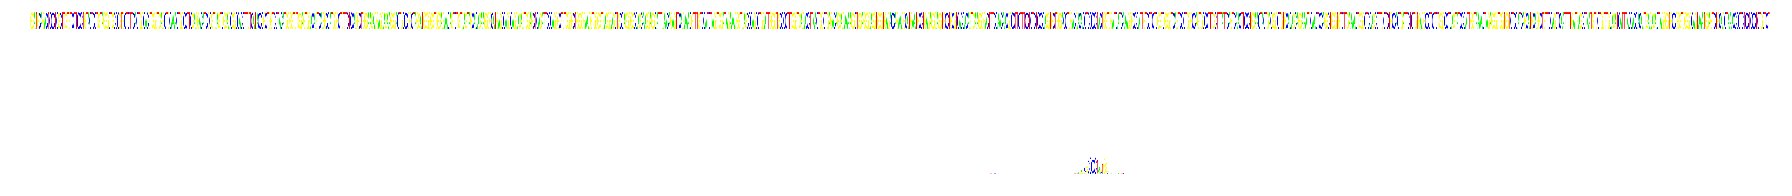

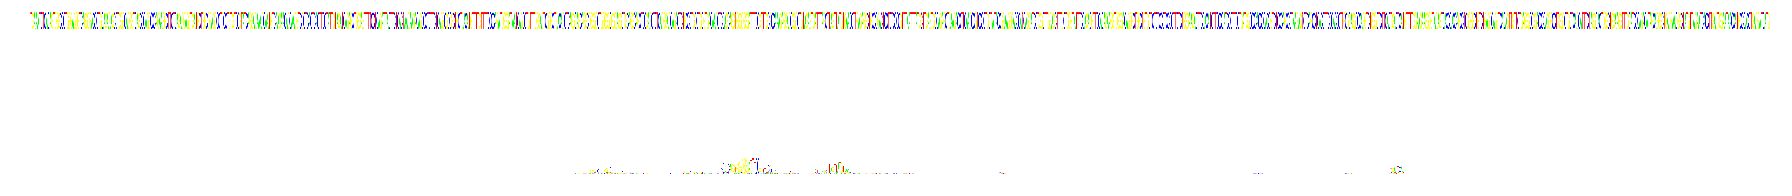

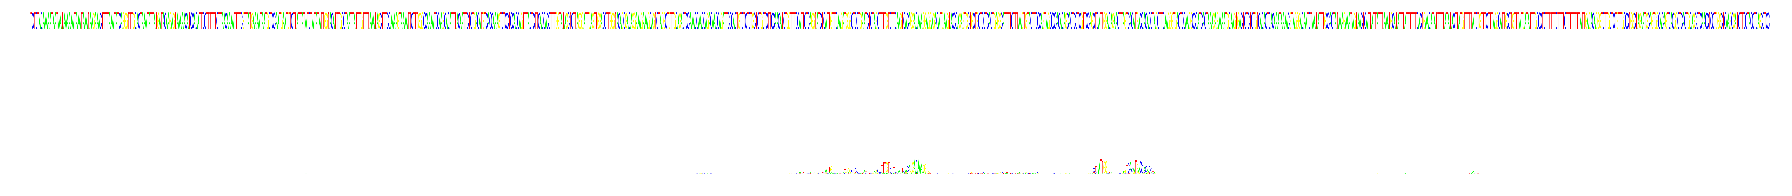

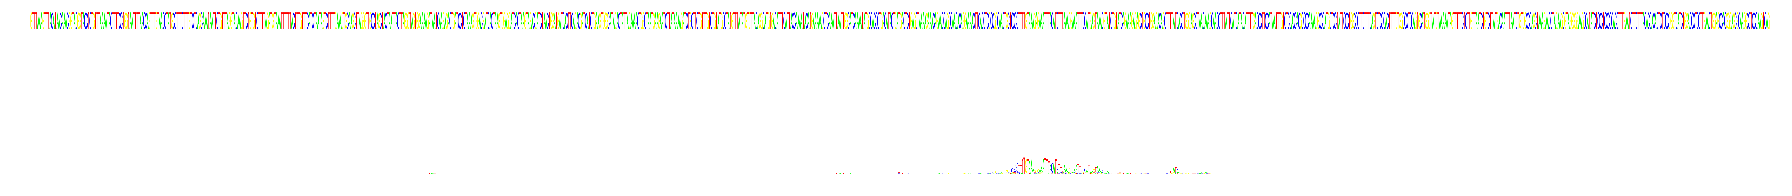

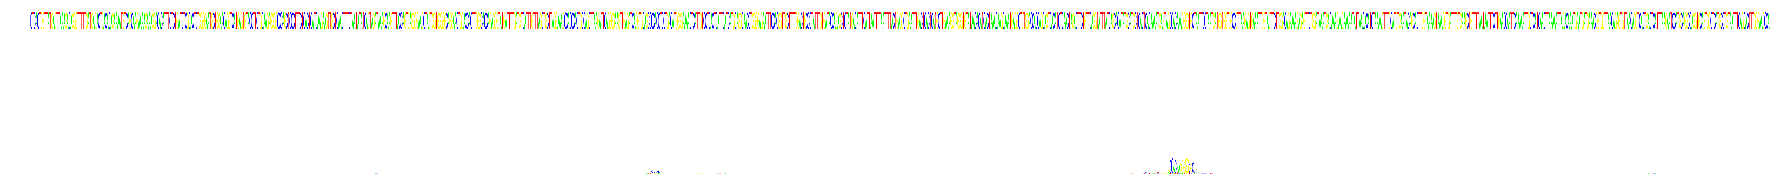

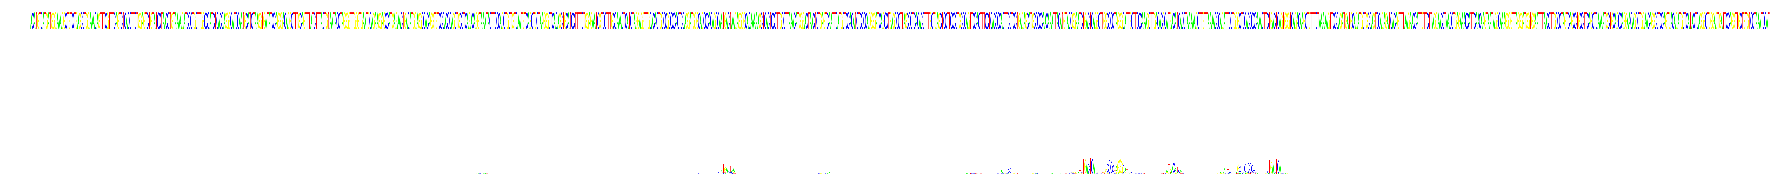

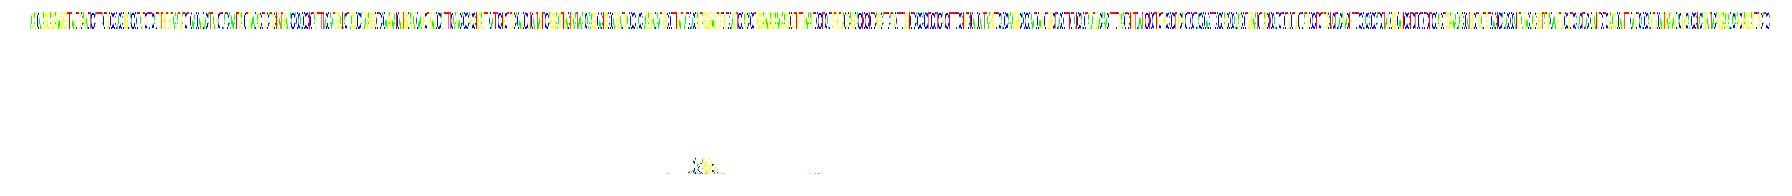

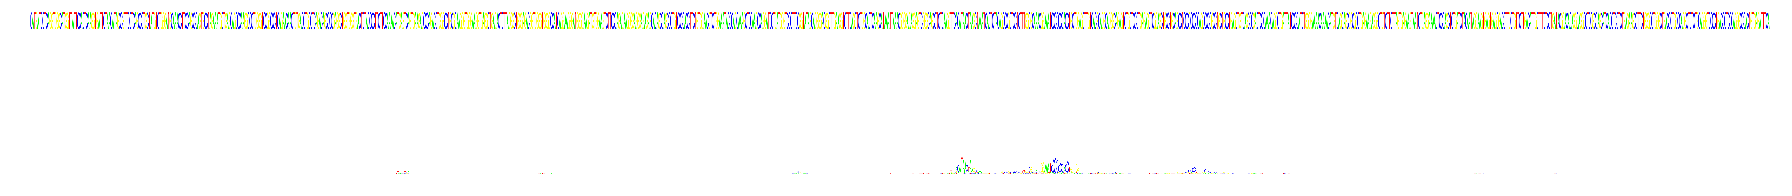

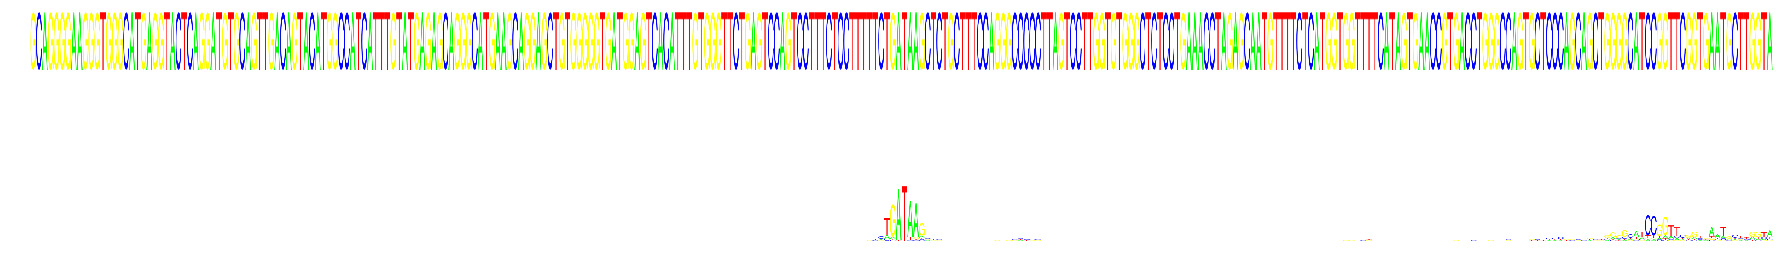

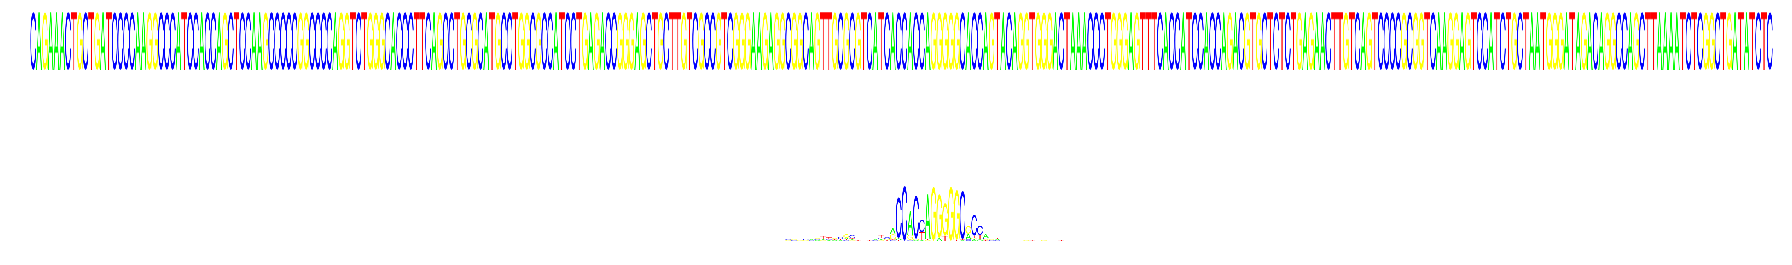

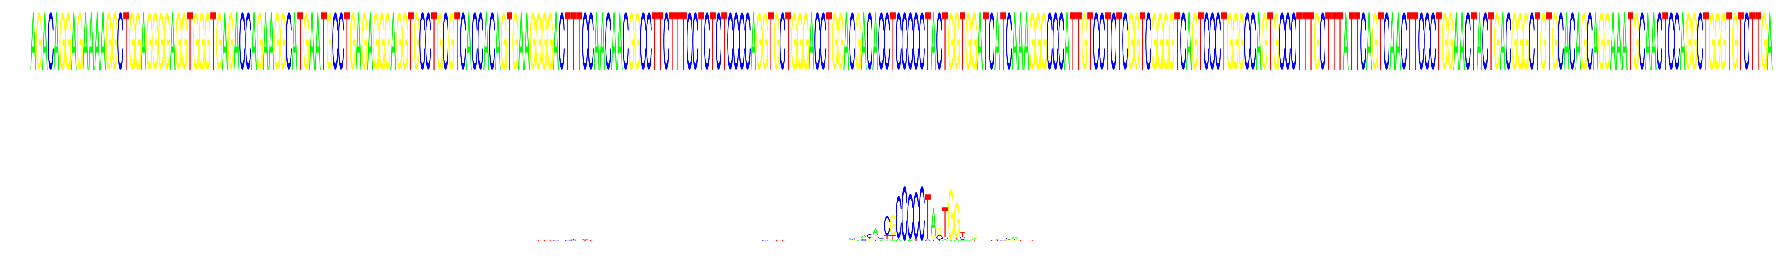

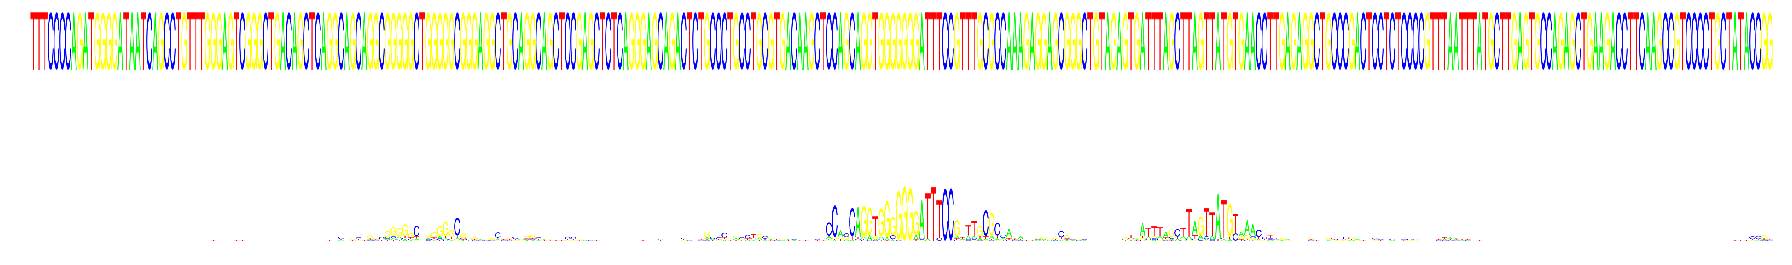

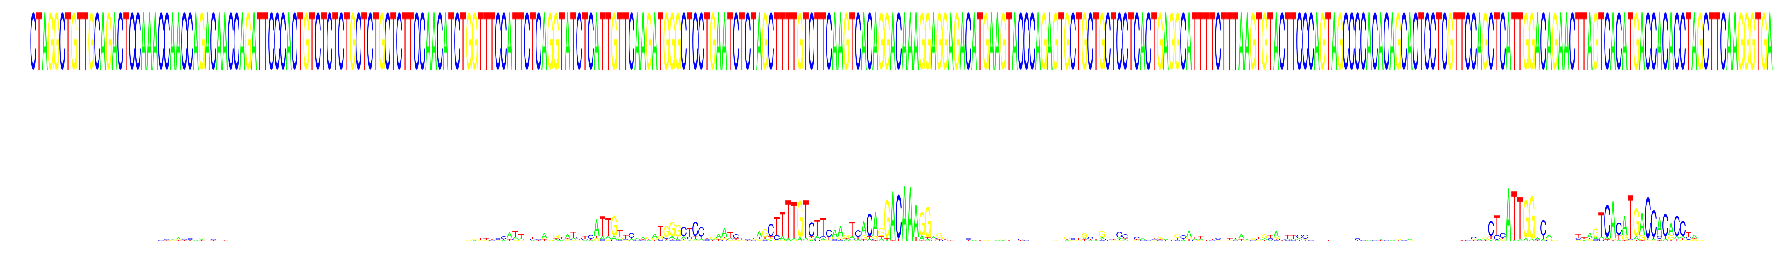

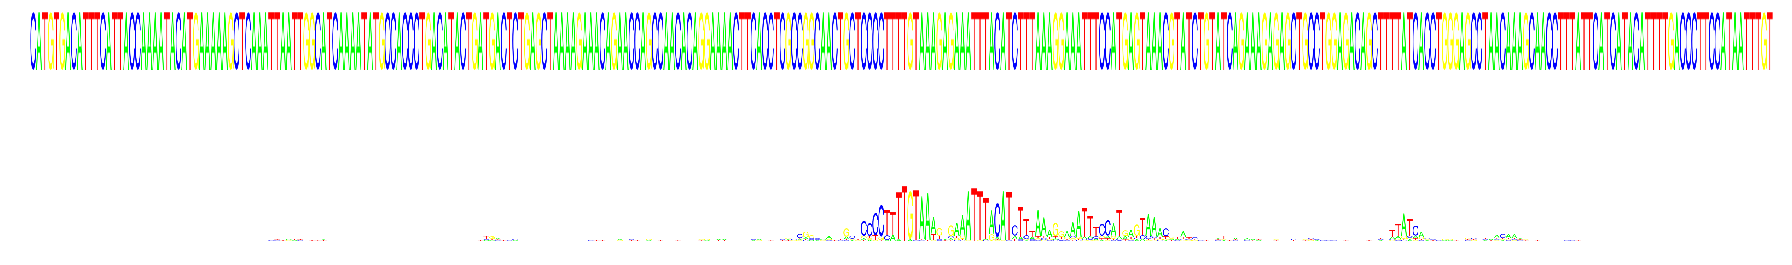

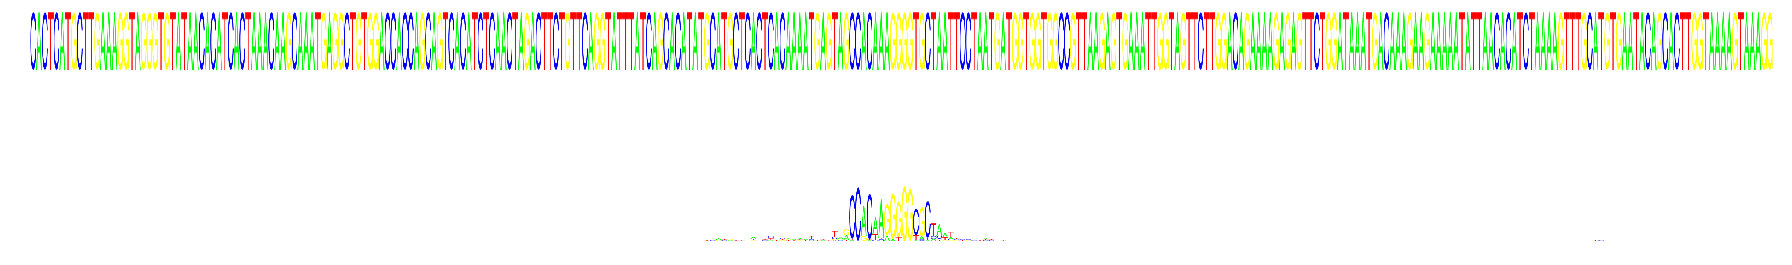

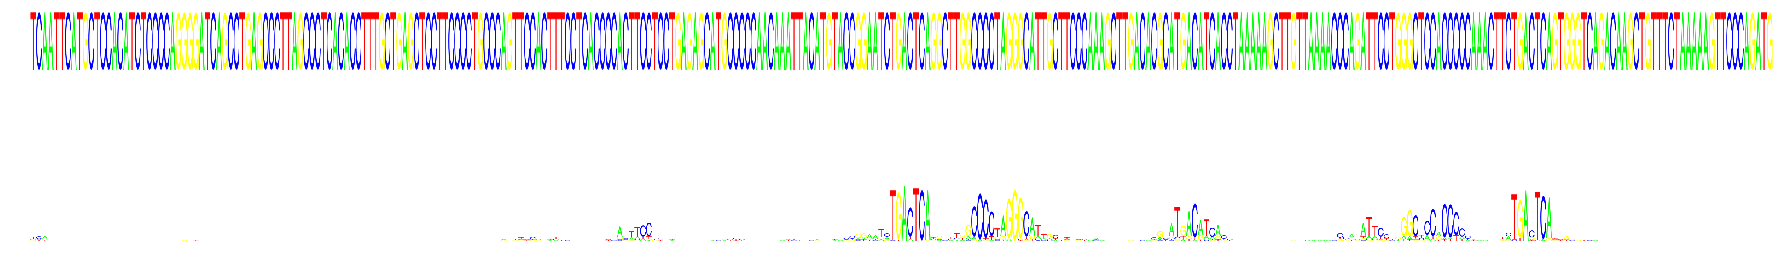

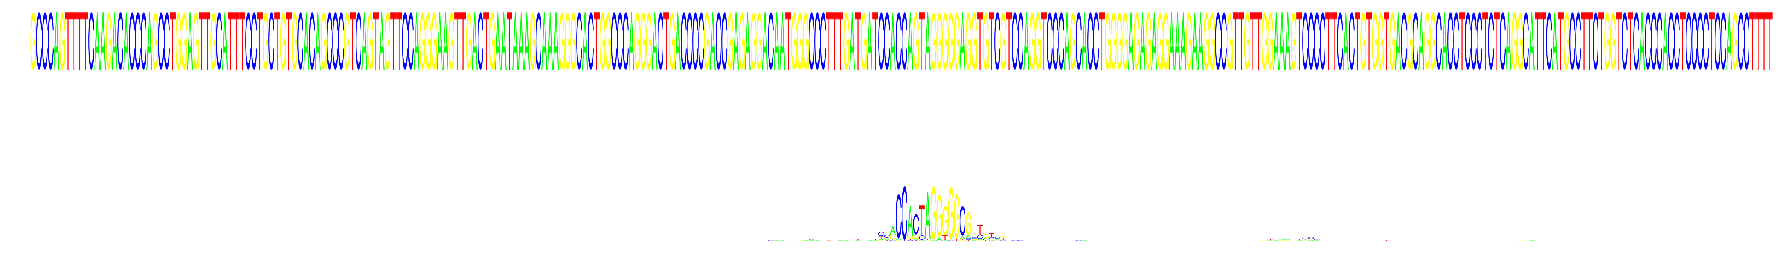

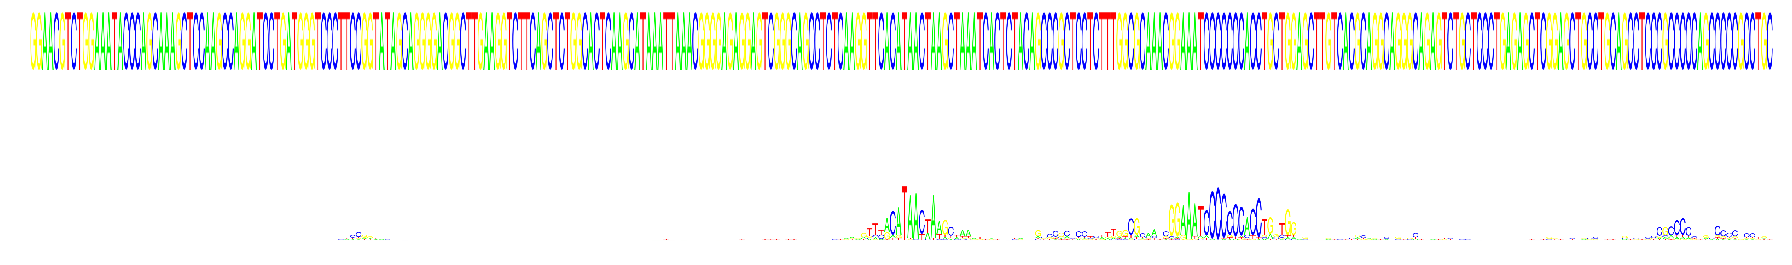

In [24]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,1]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


# h1-hESC

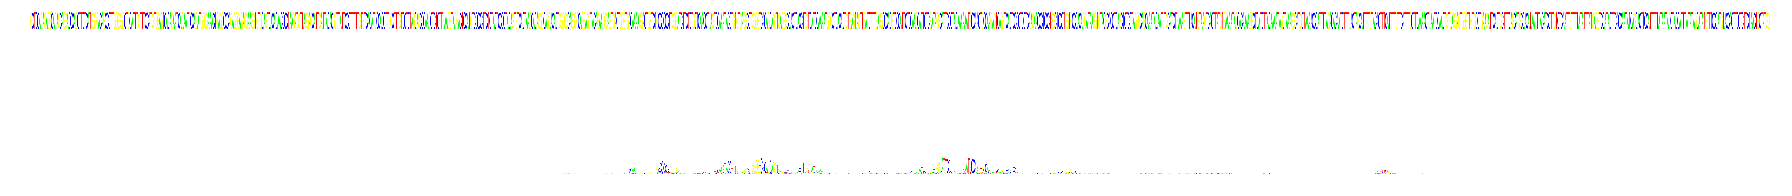

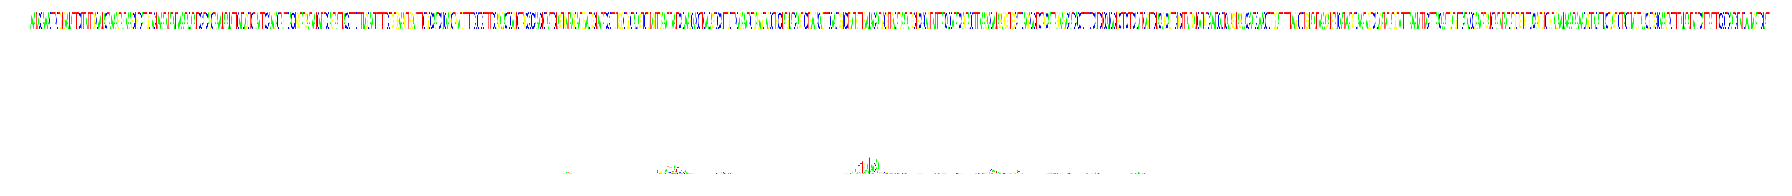

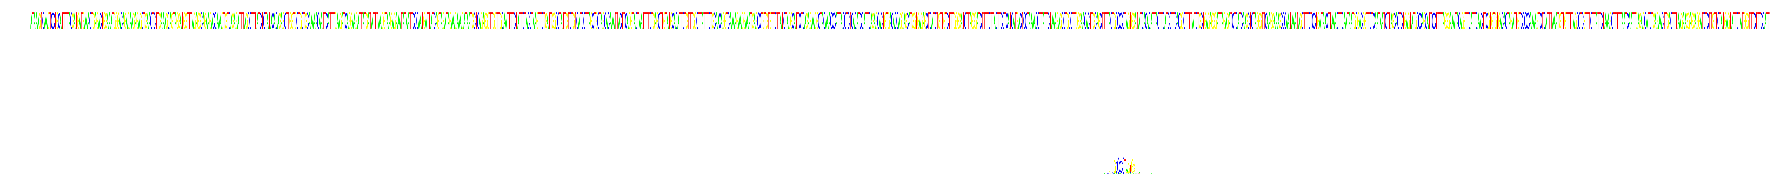

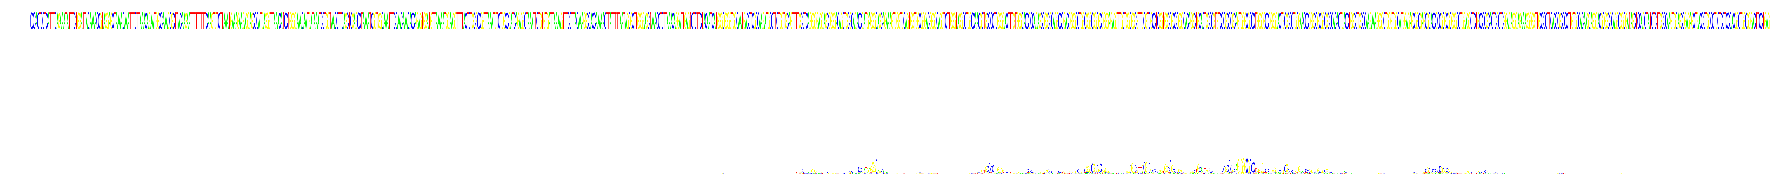

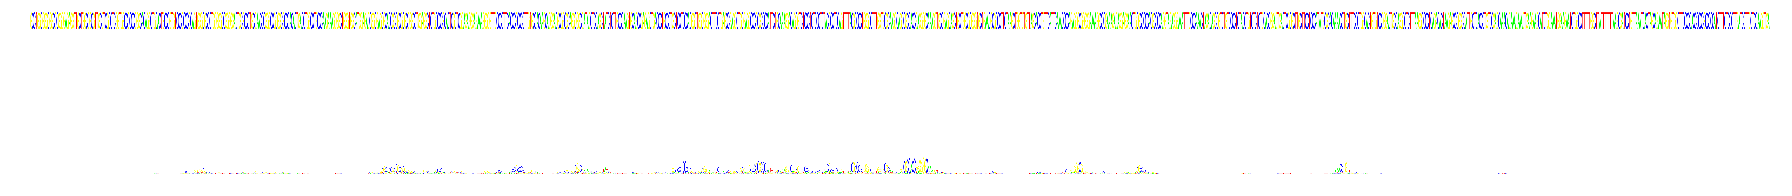

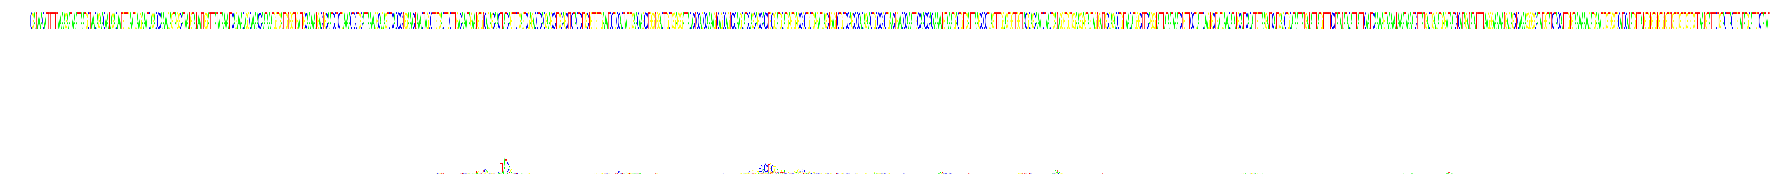

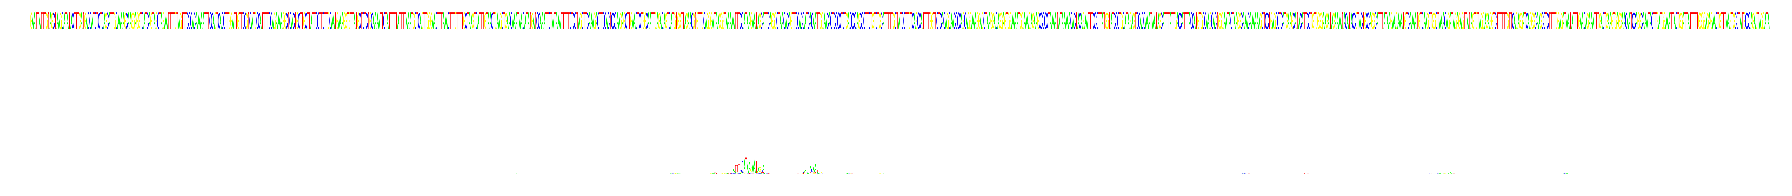

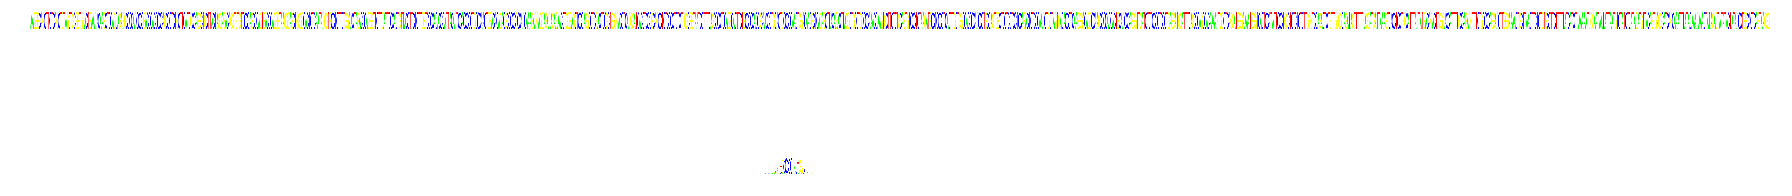

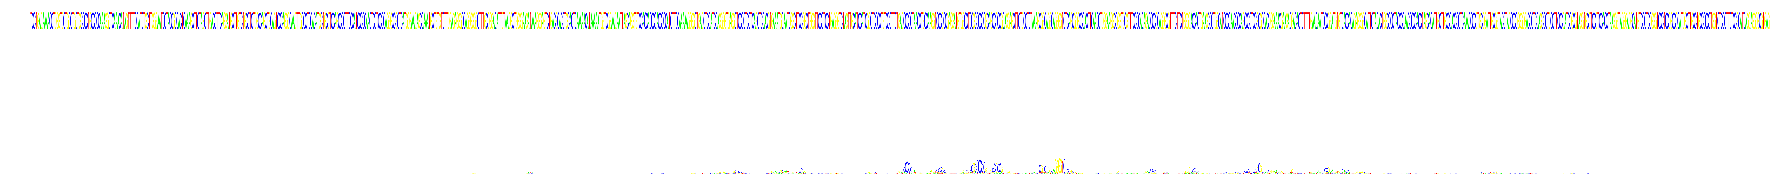

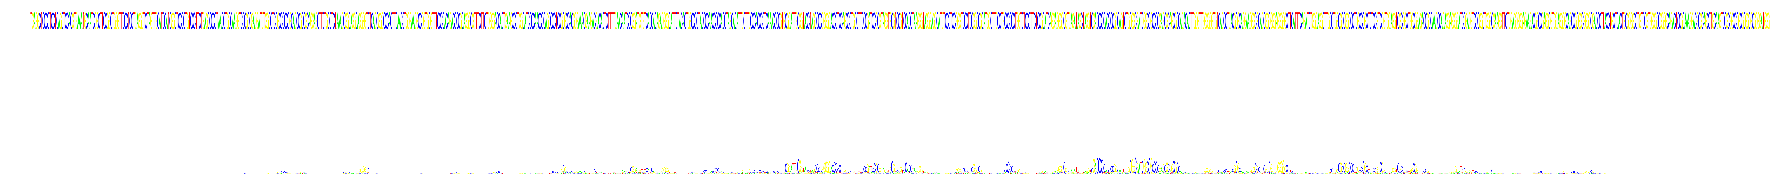

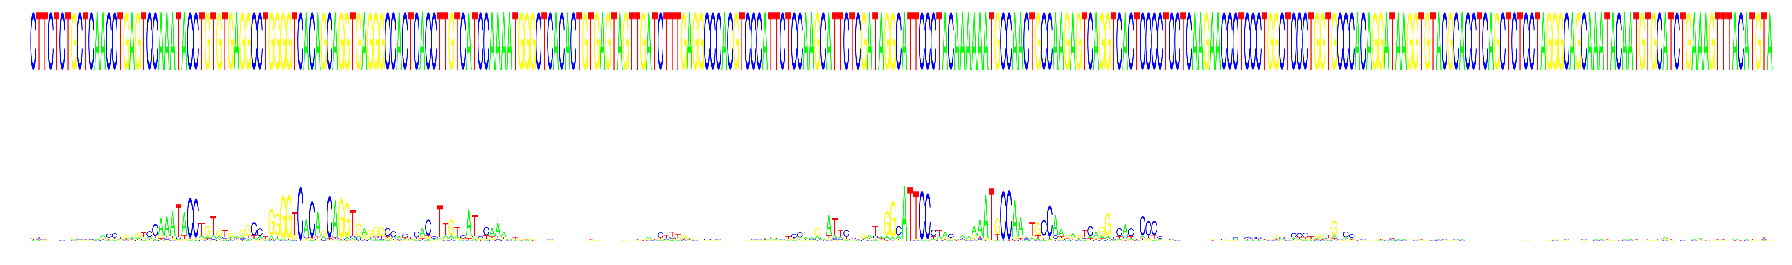

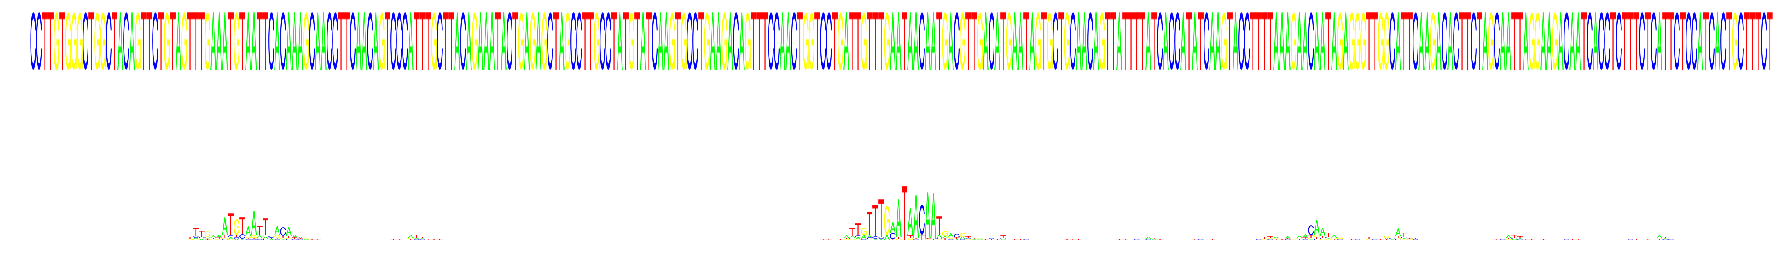

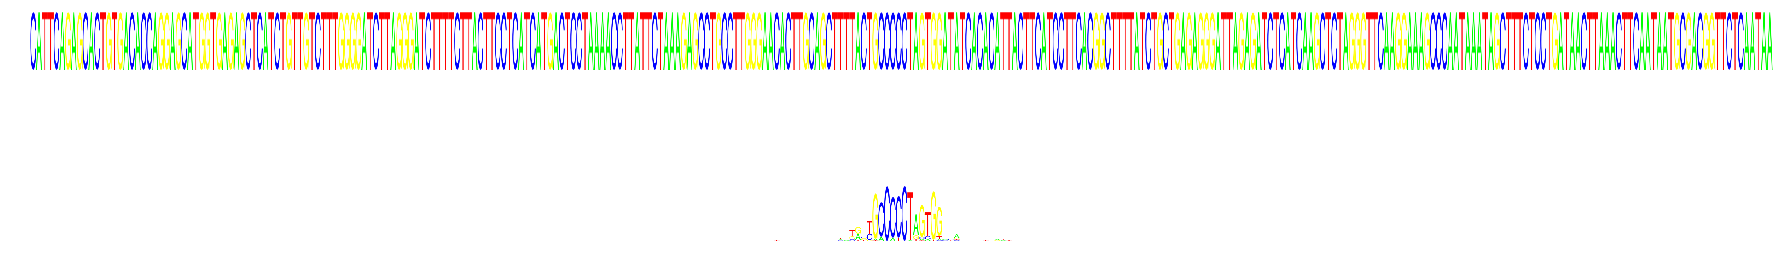

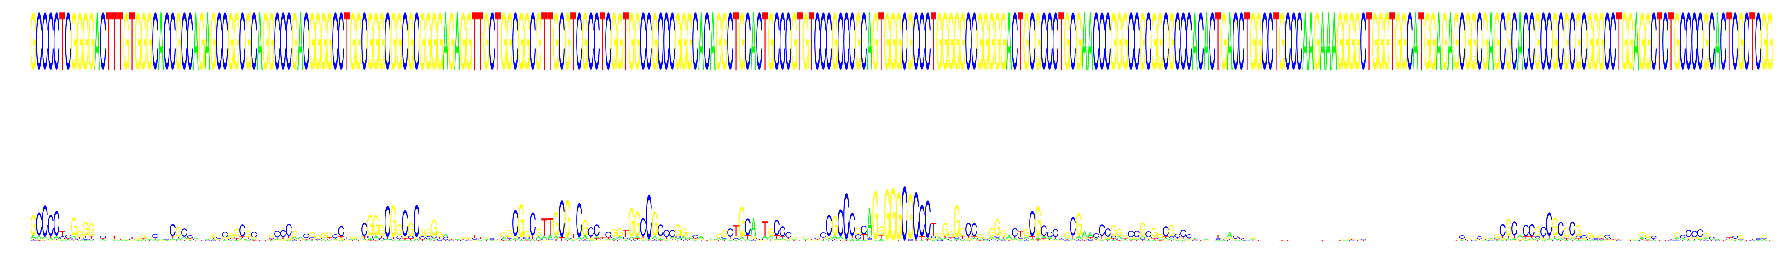

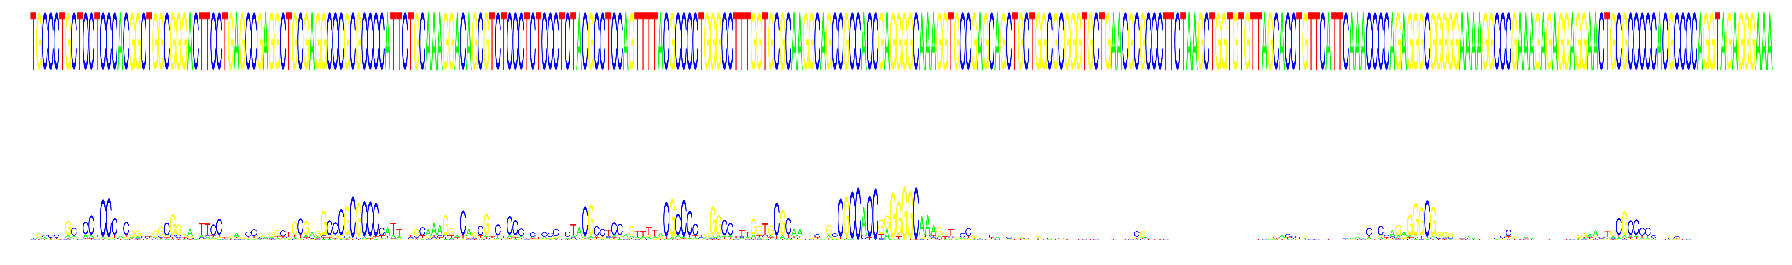

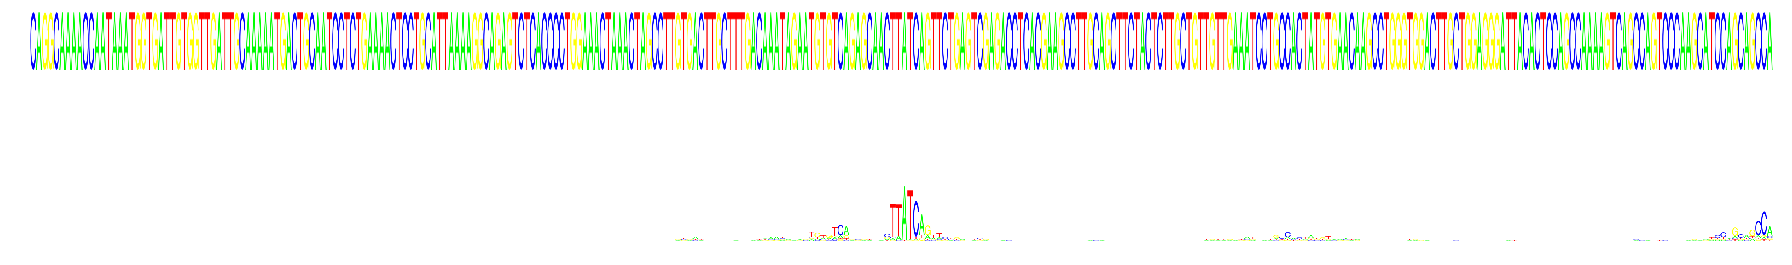

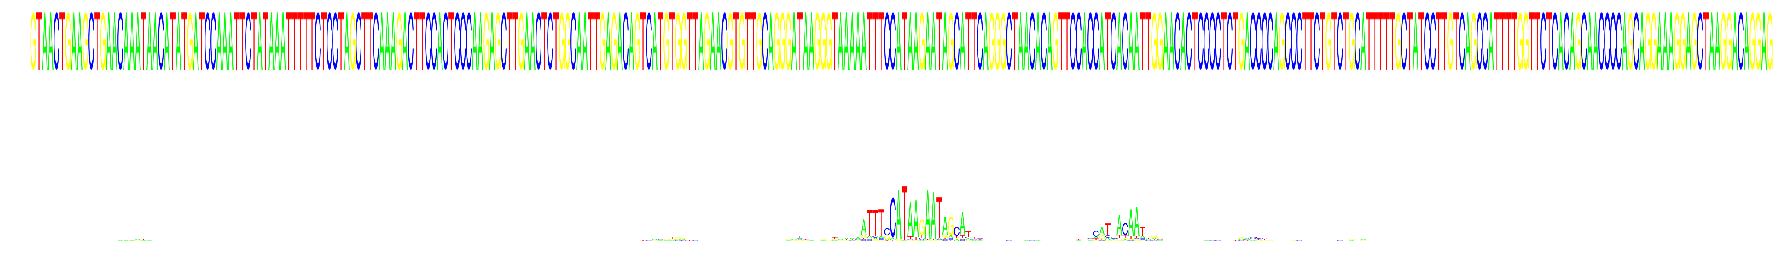

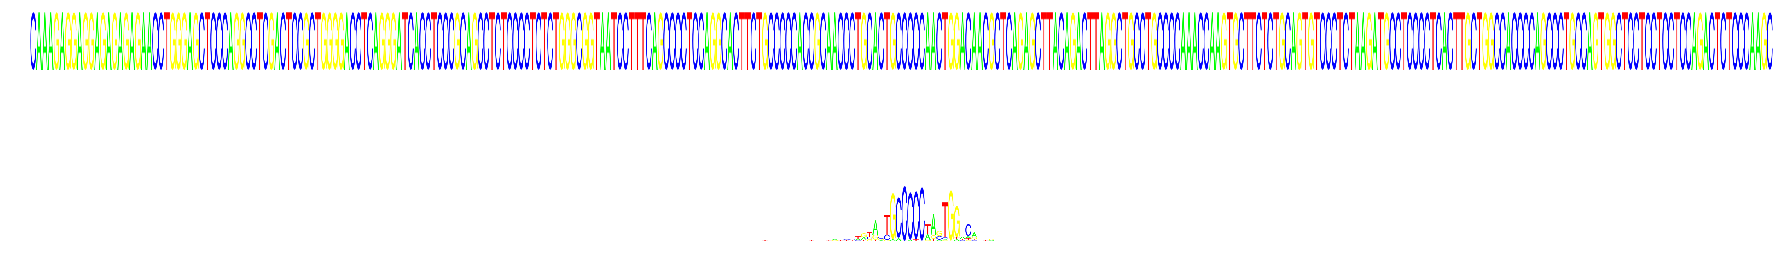

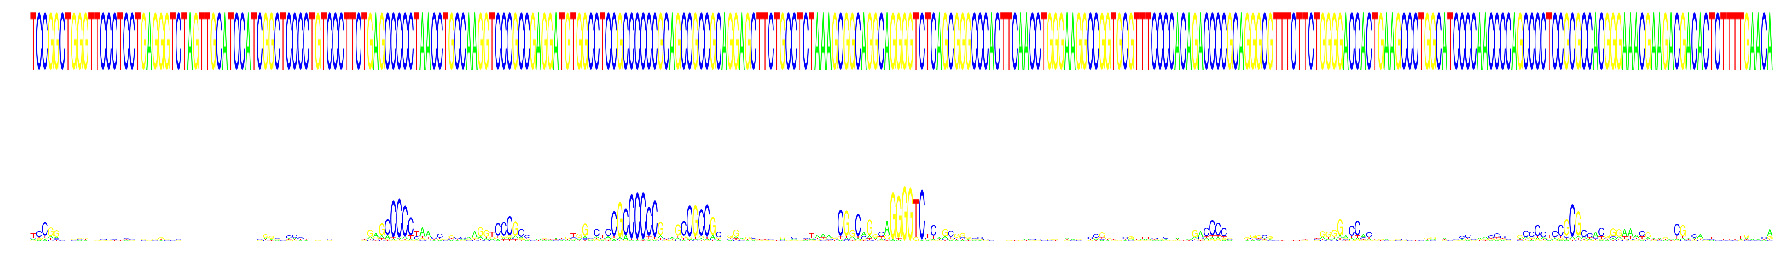

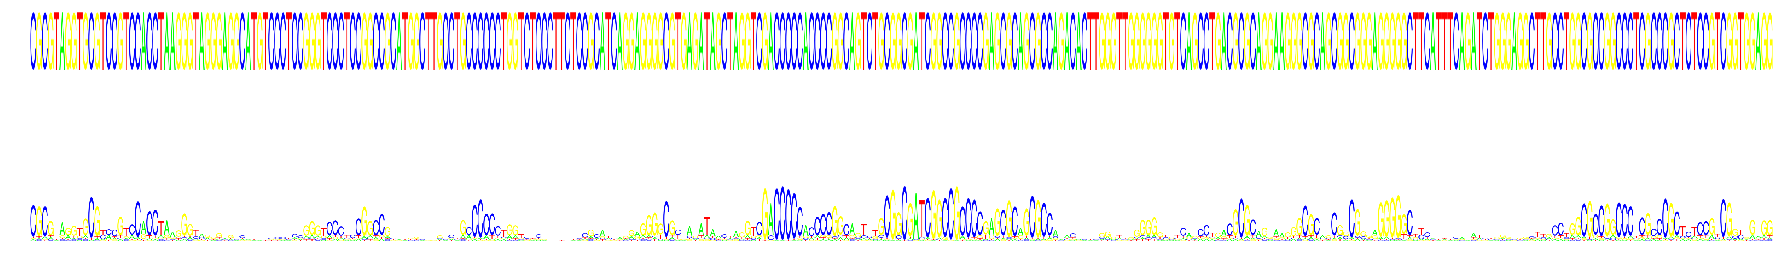

In [25]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,2]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


# HeLA

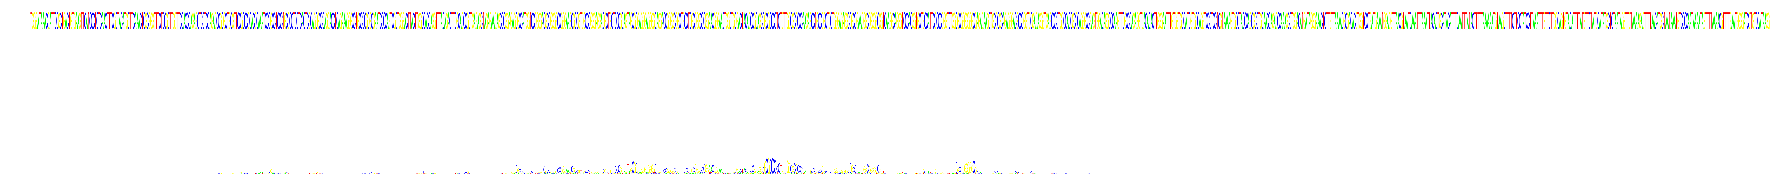

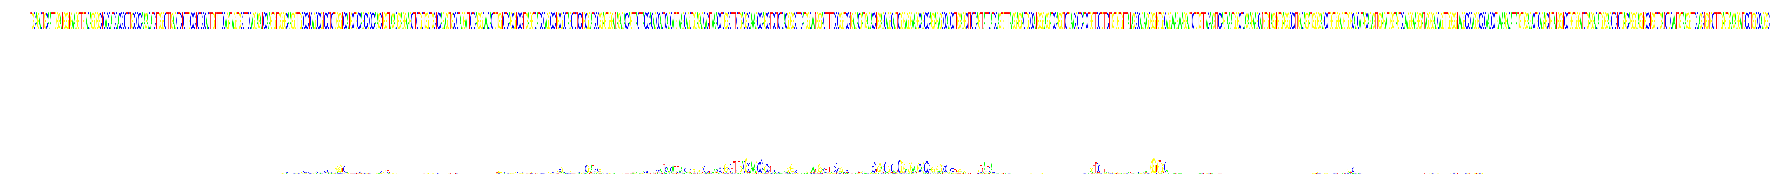

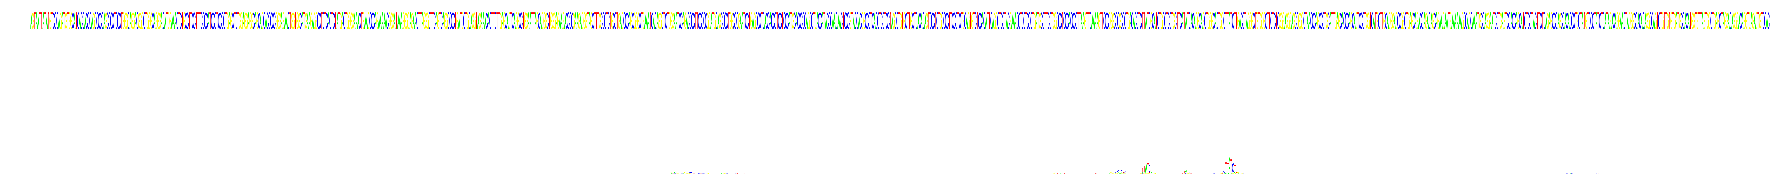

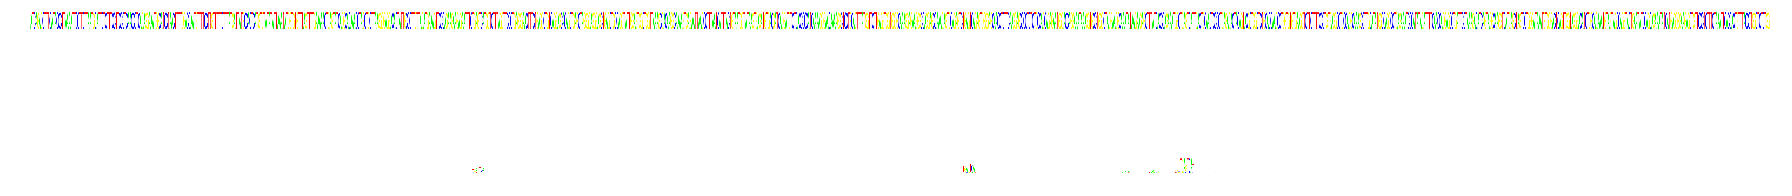

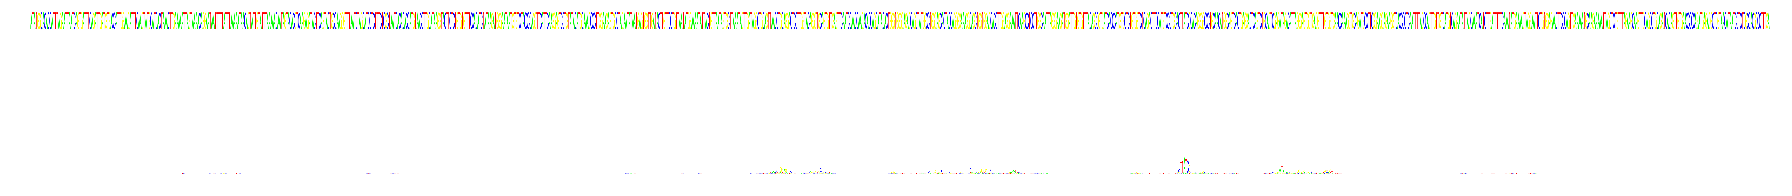

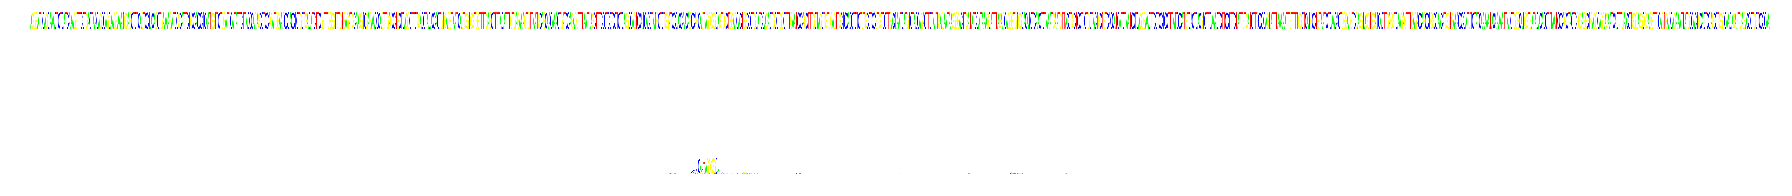

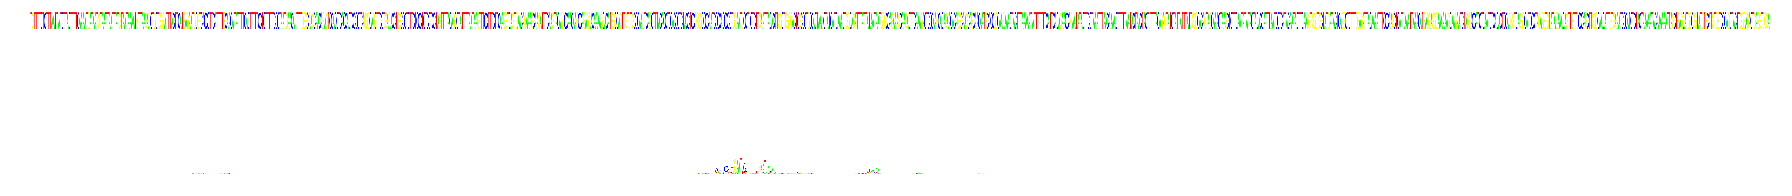

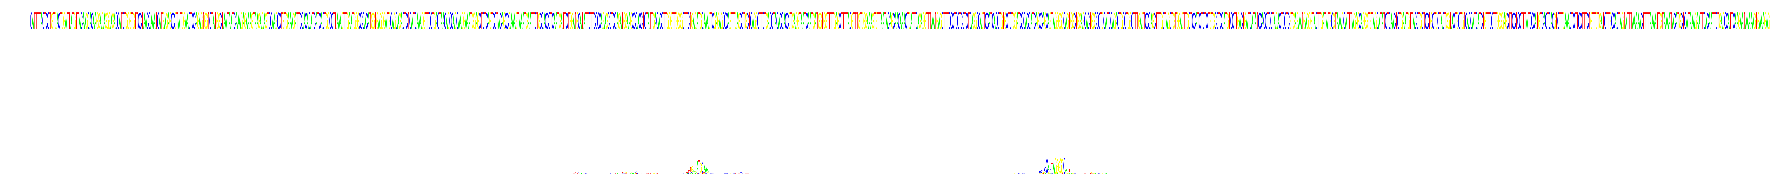

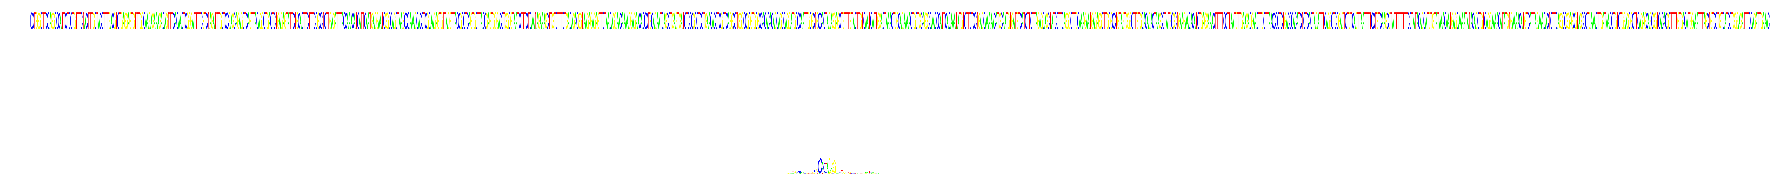

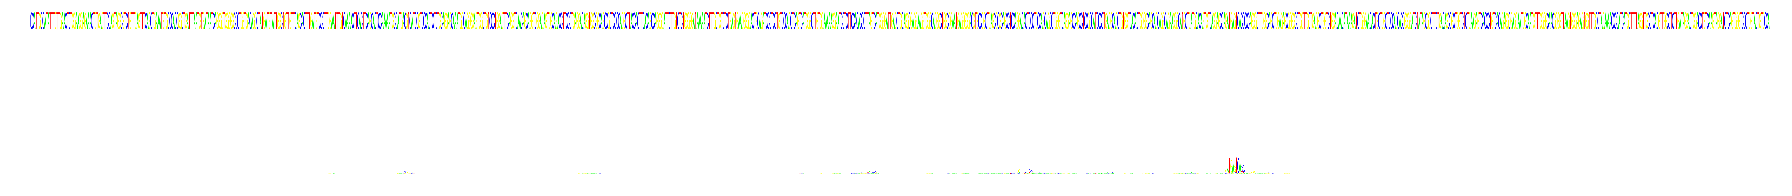

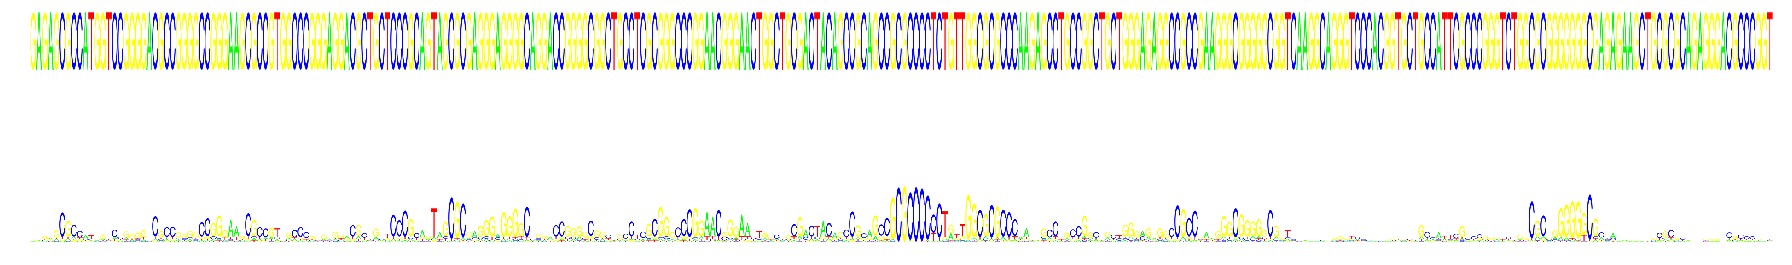

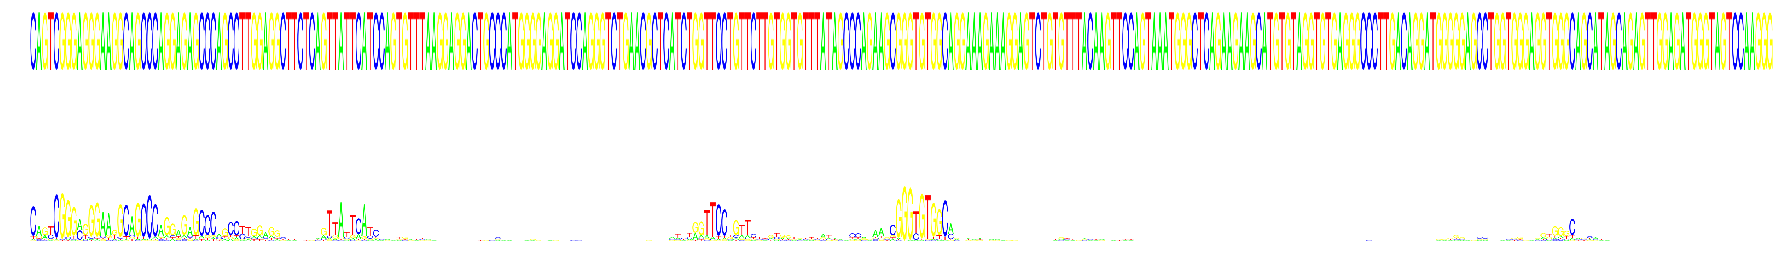

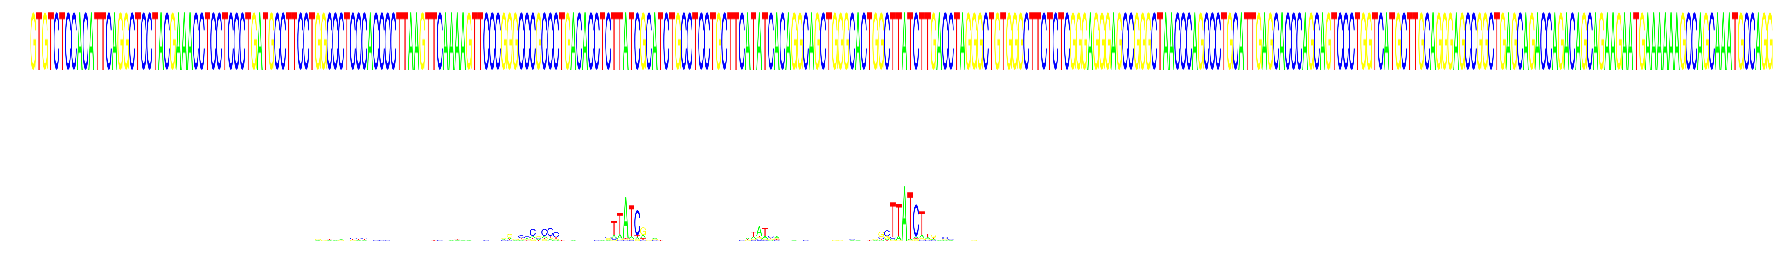

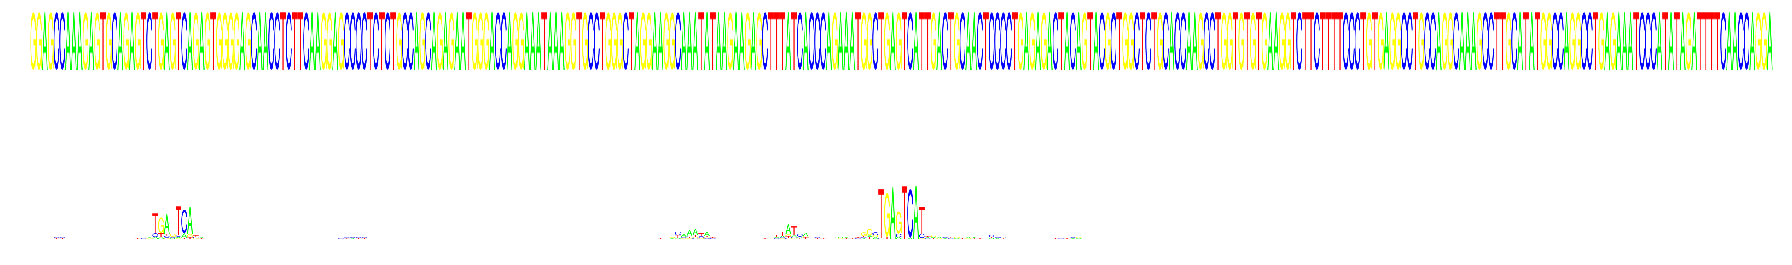

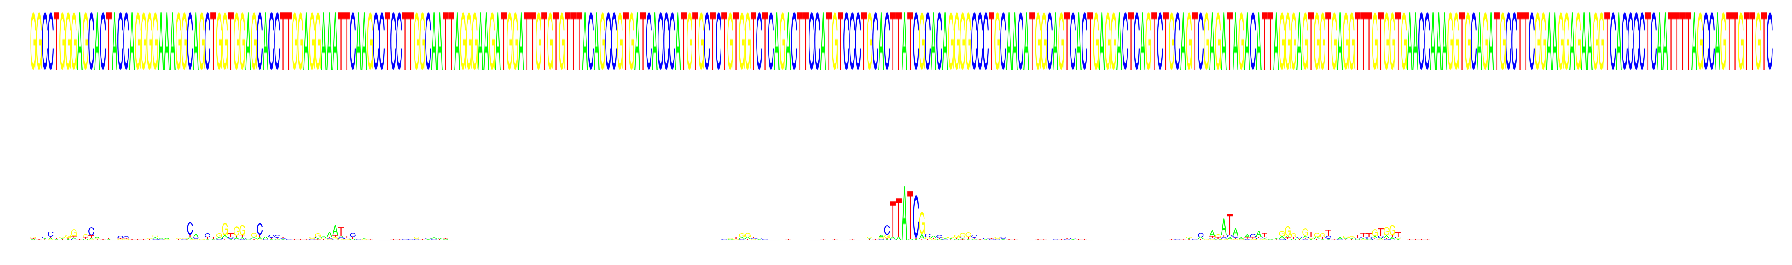

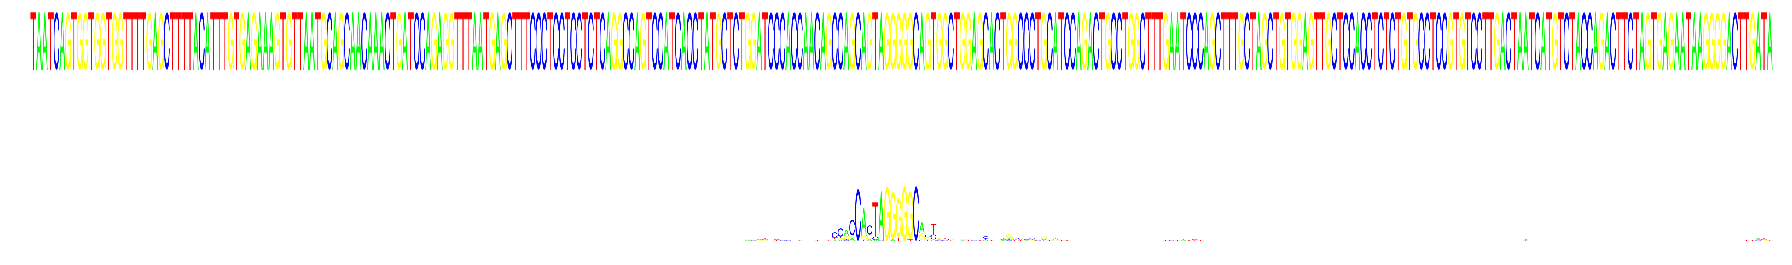

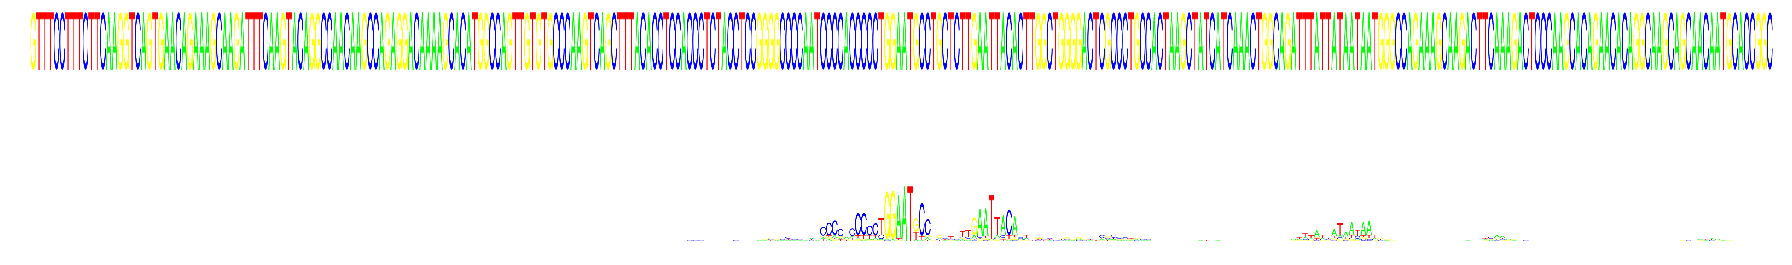

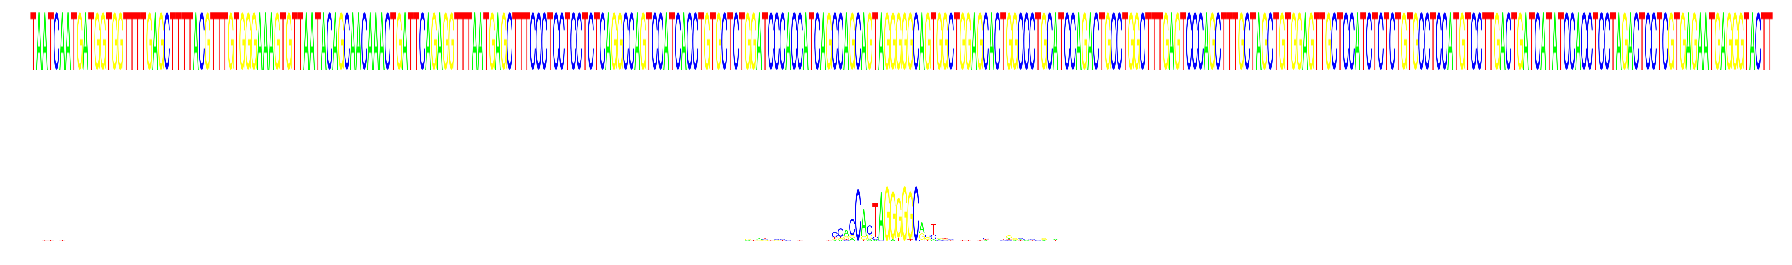

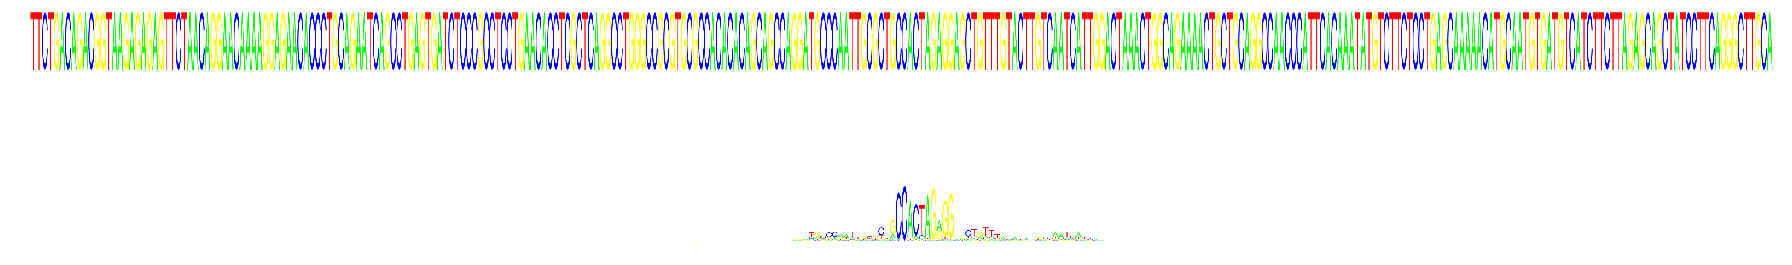

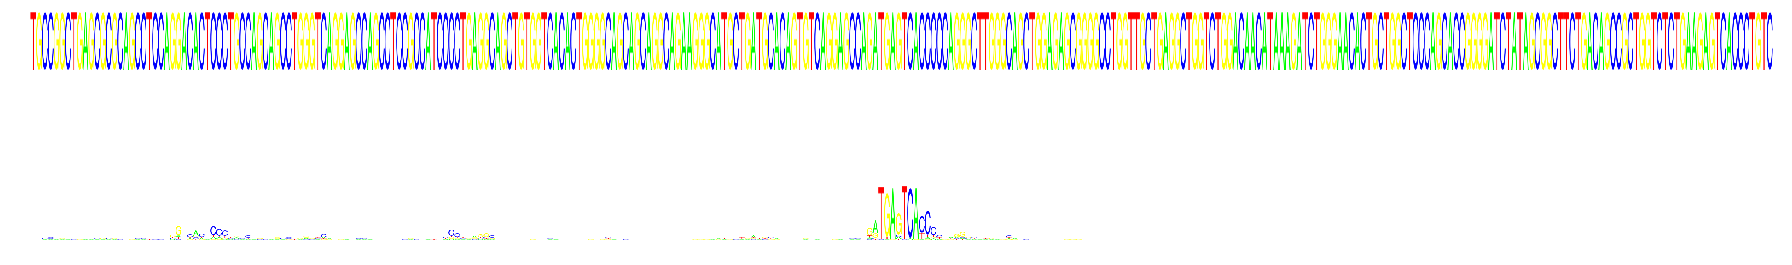

In [26]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,3]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


# HepG2

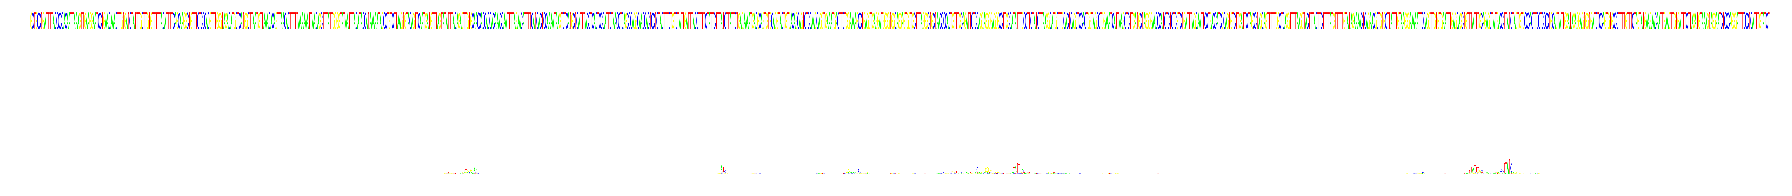

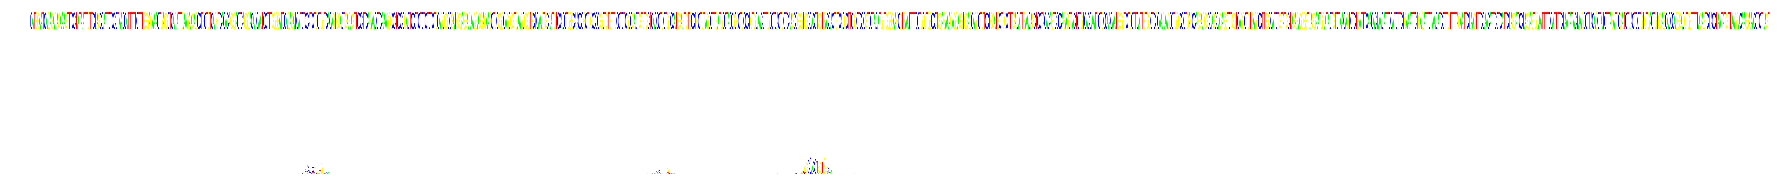

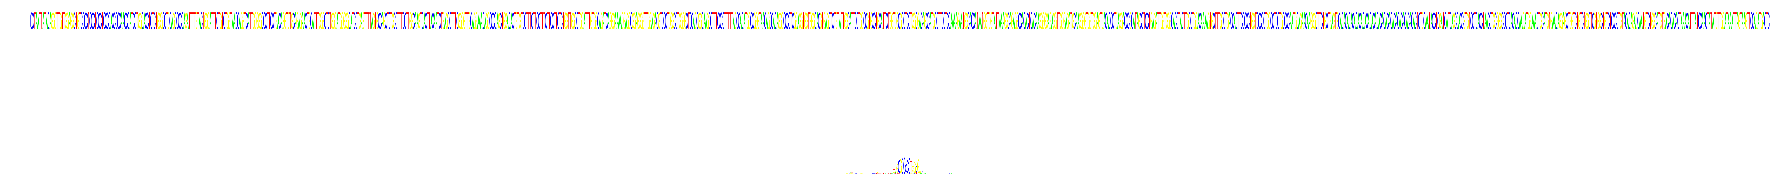

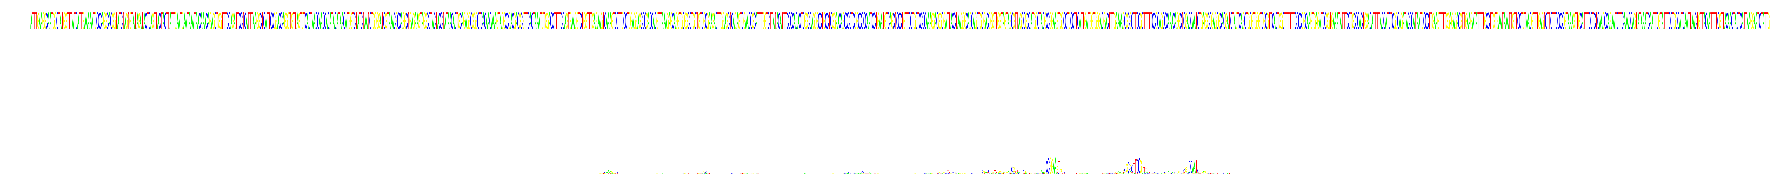

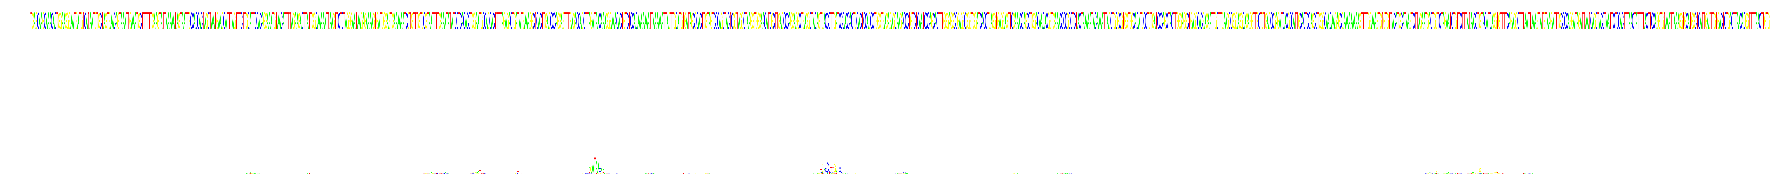

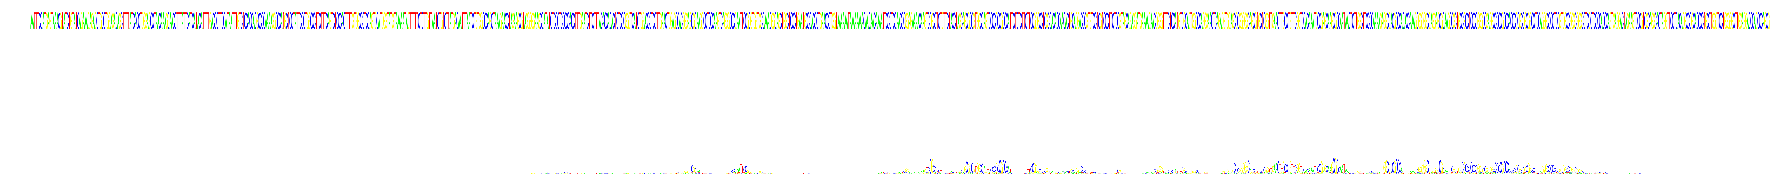

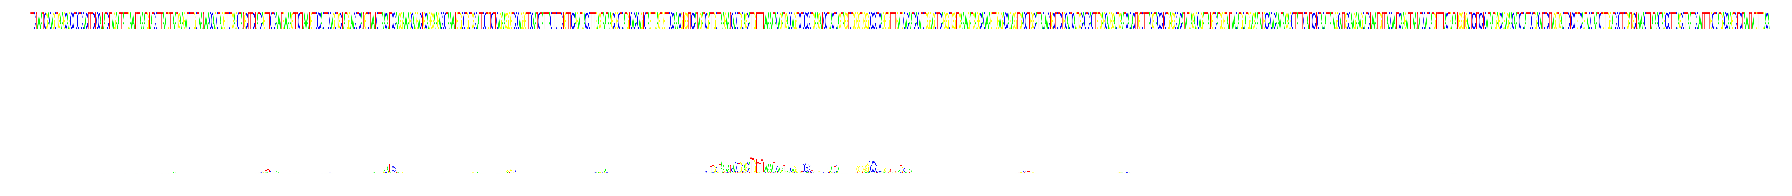

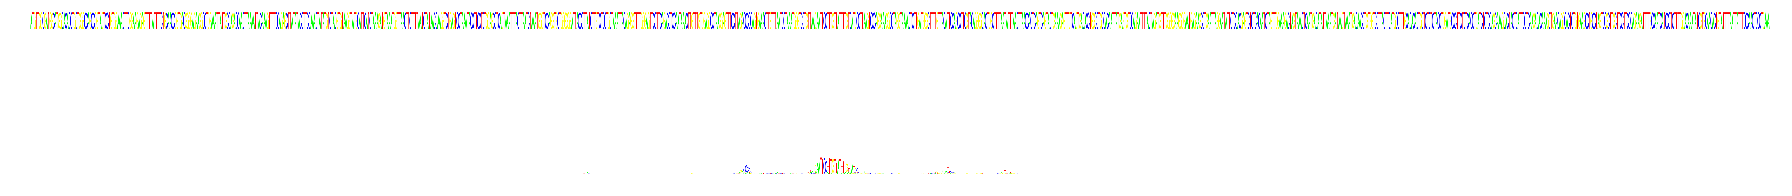

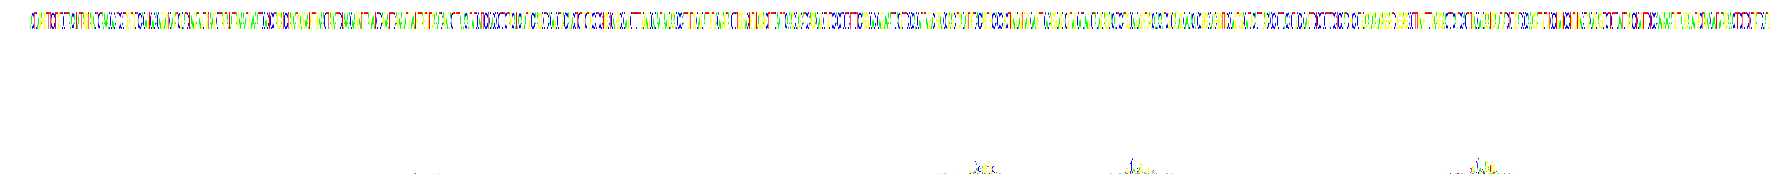

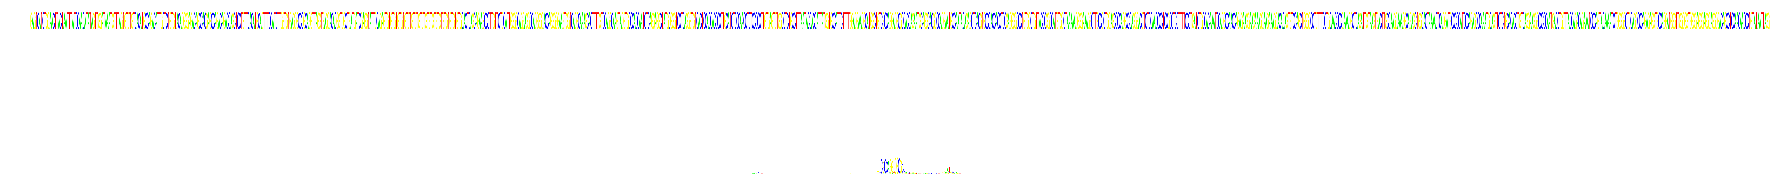

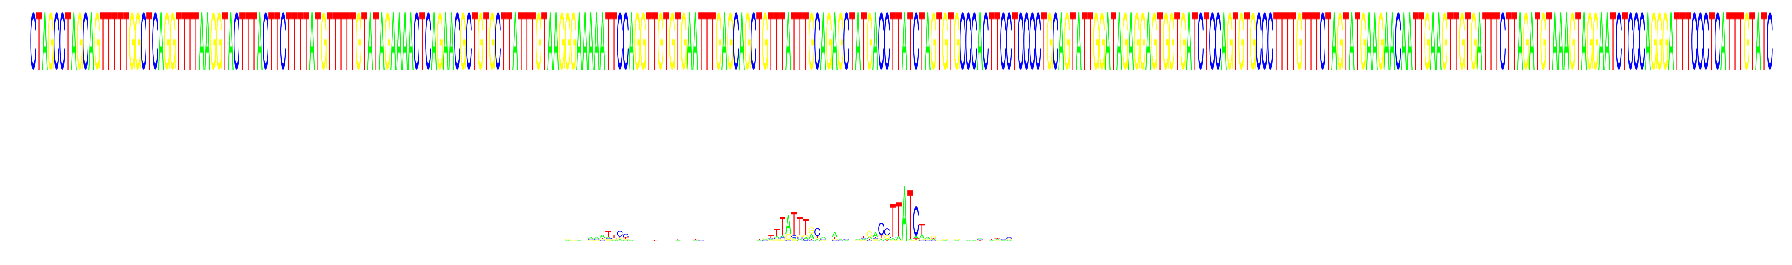

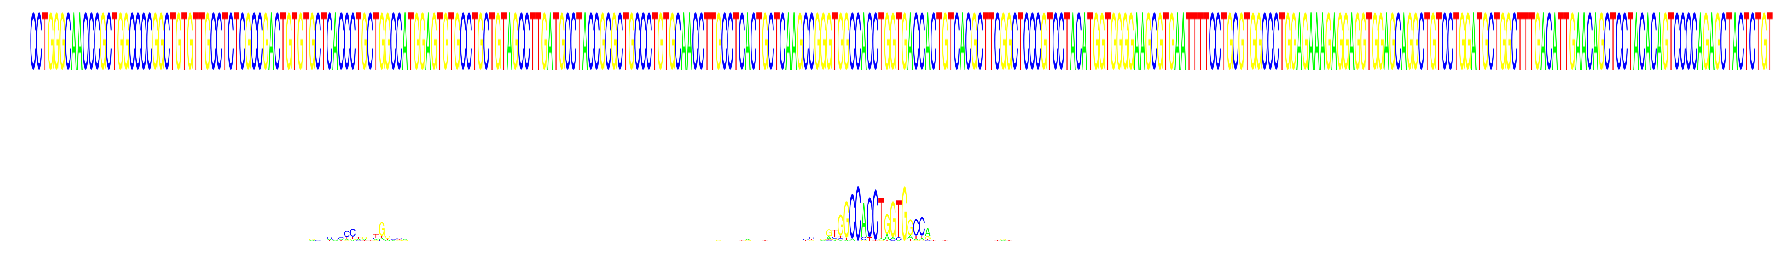

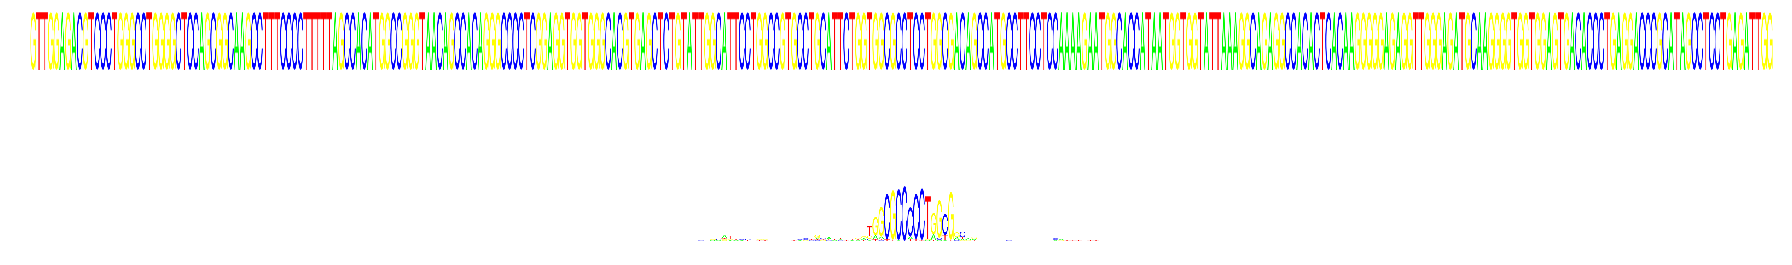

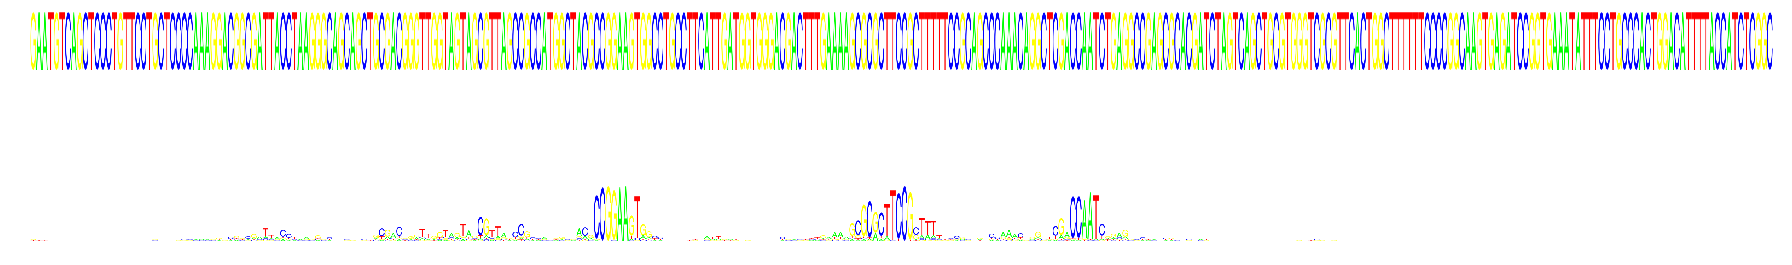

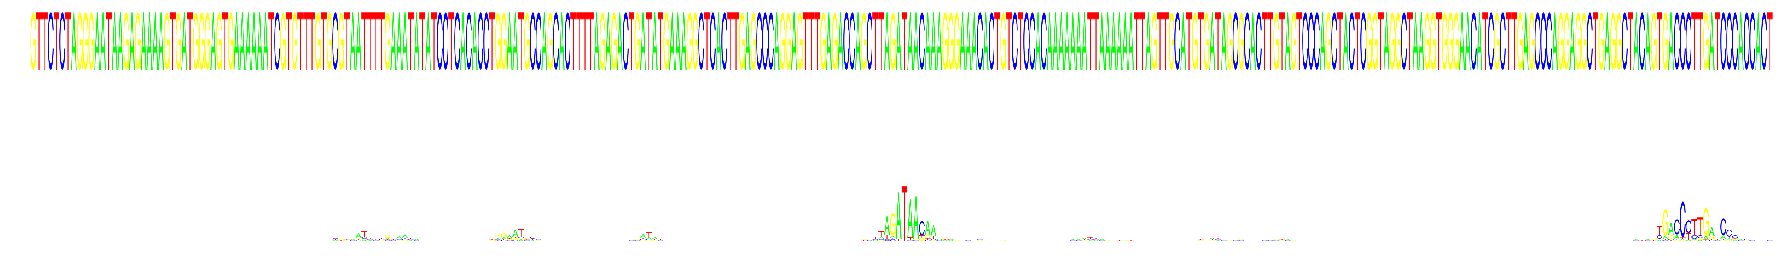

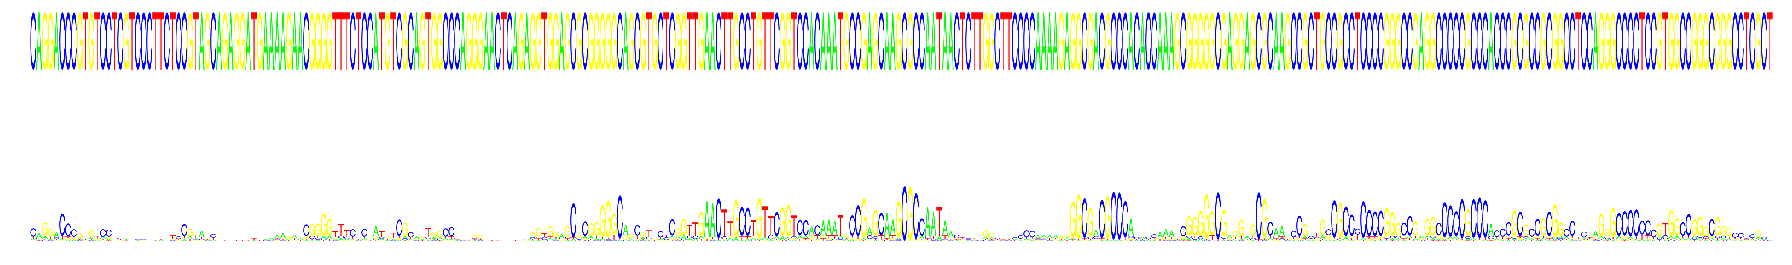

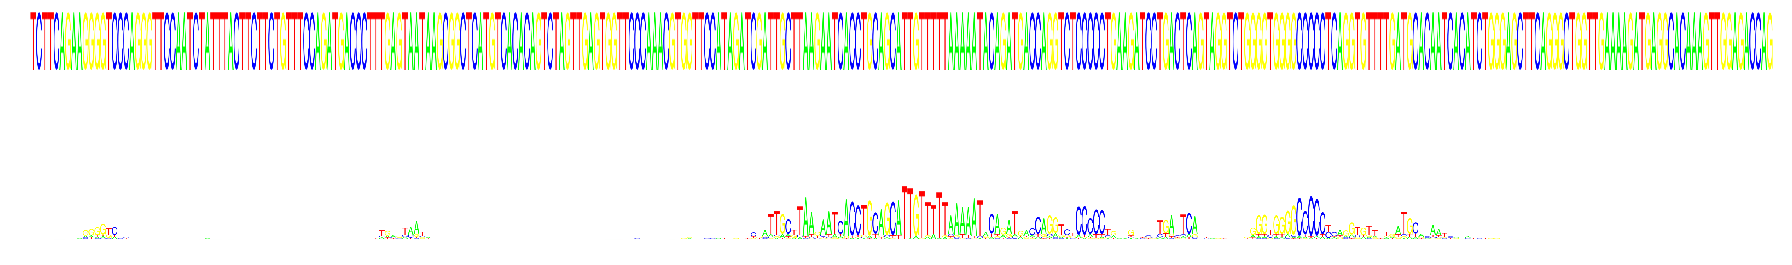

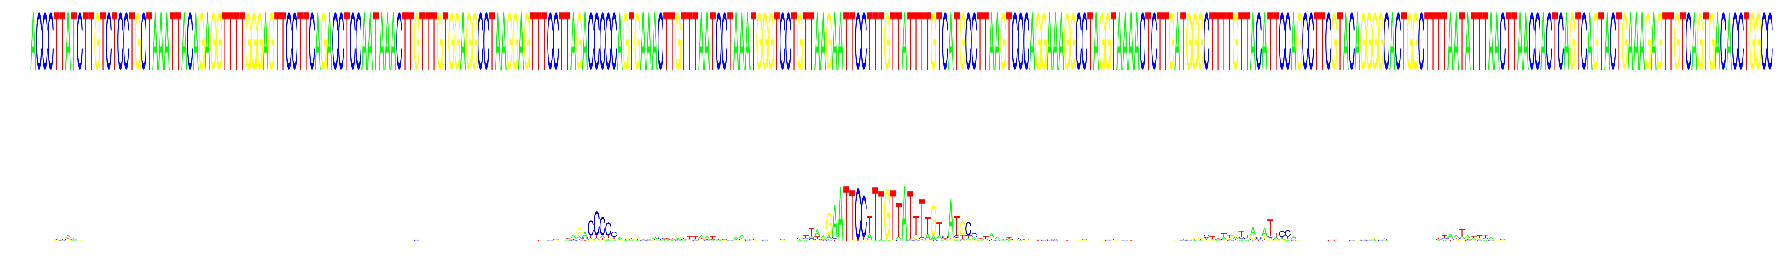

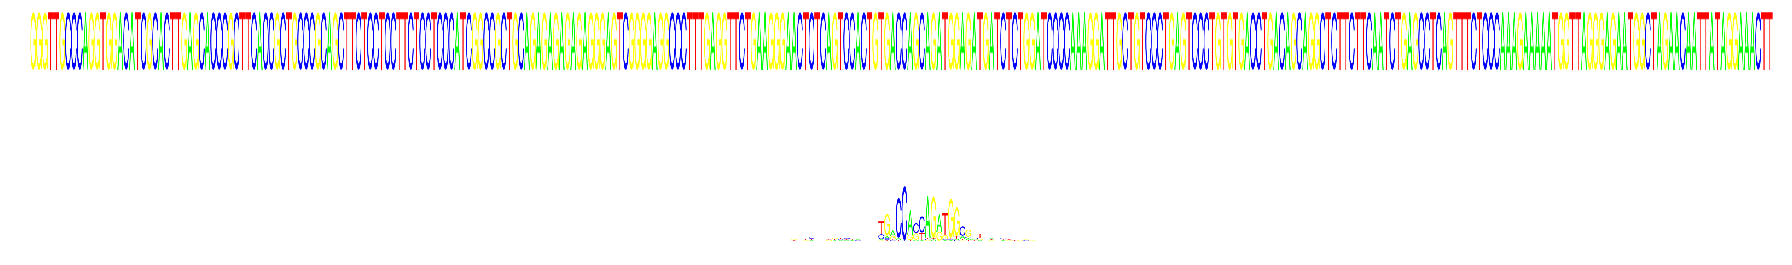

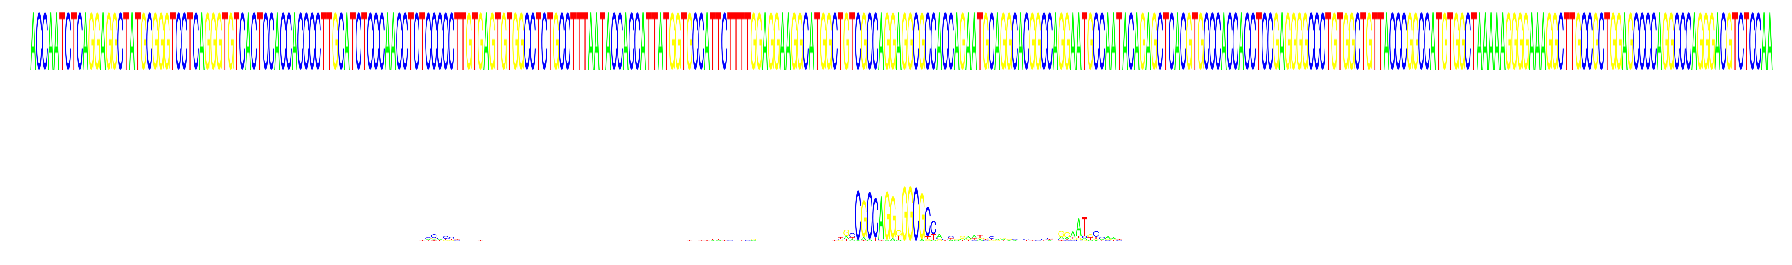

In [27]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,4]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


# K562

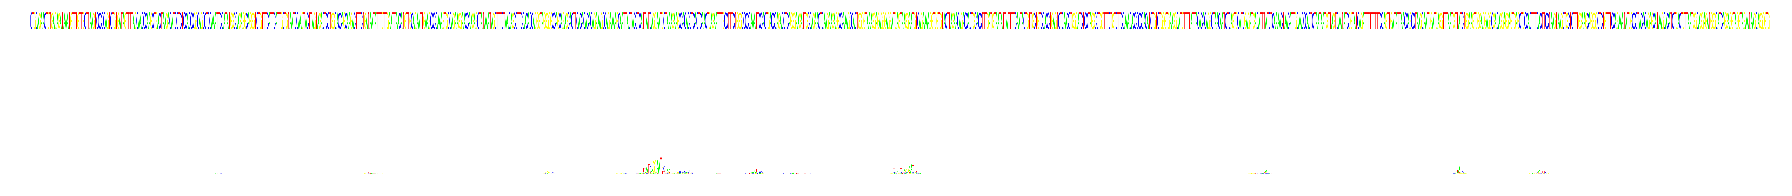

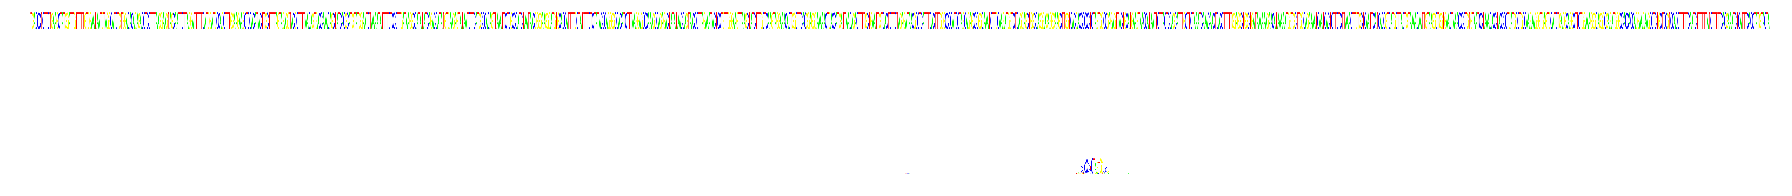

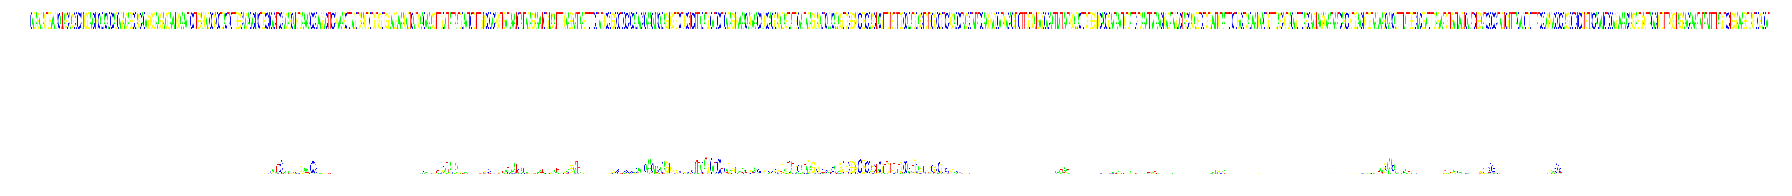

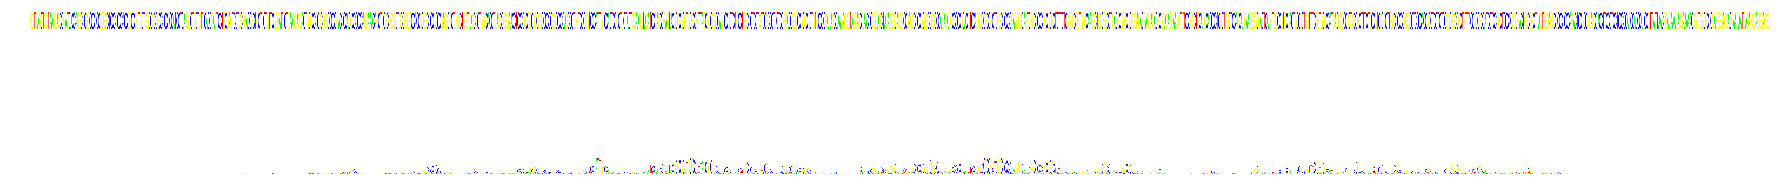

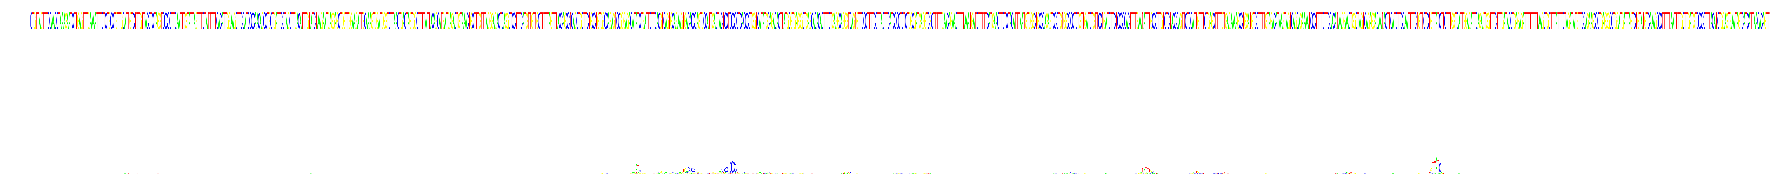

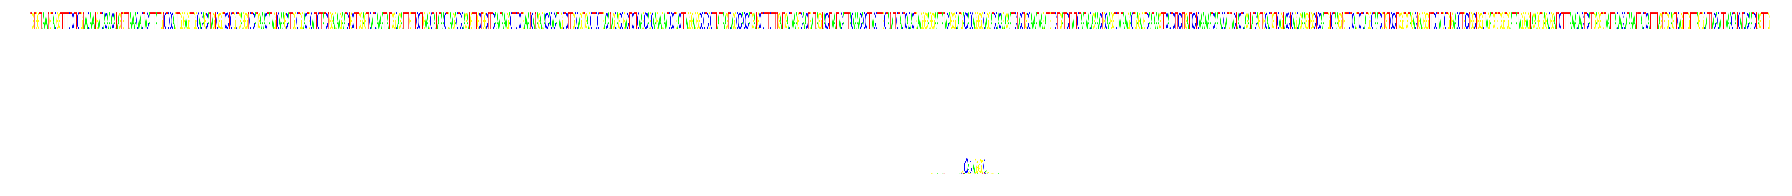

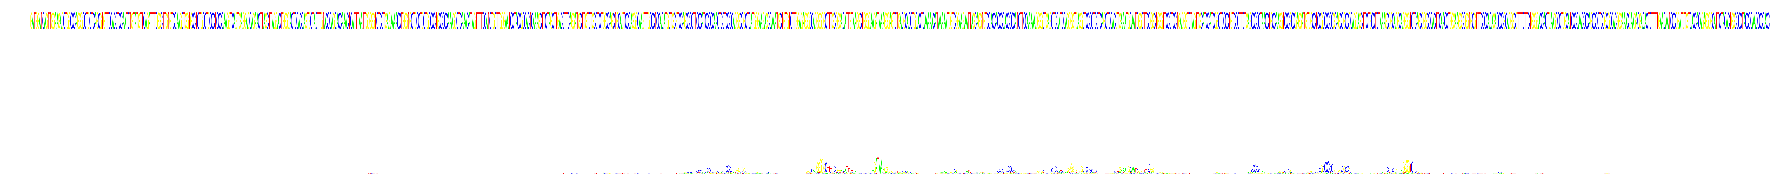

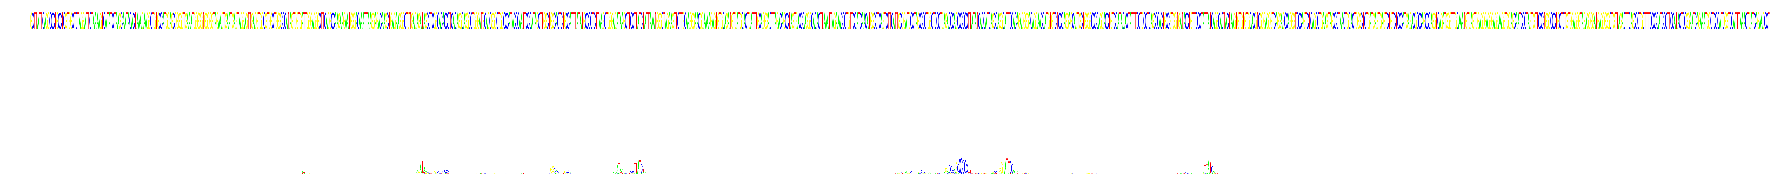

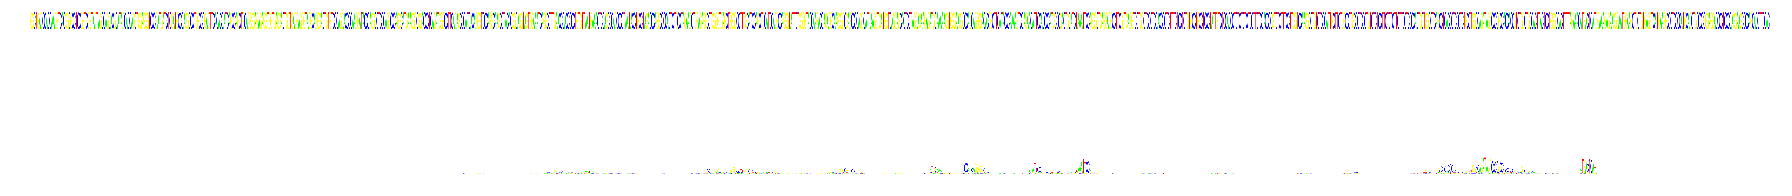

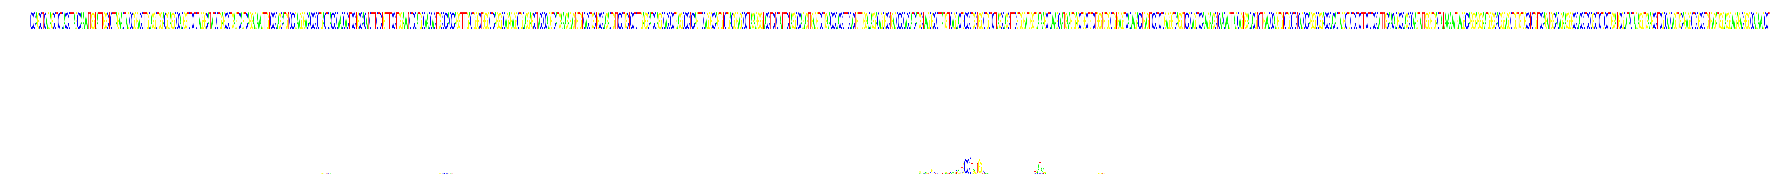

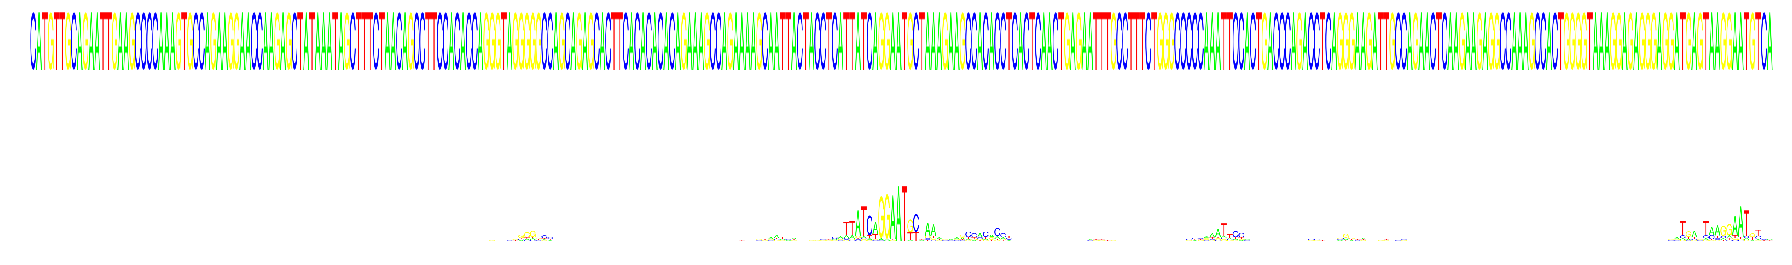

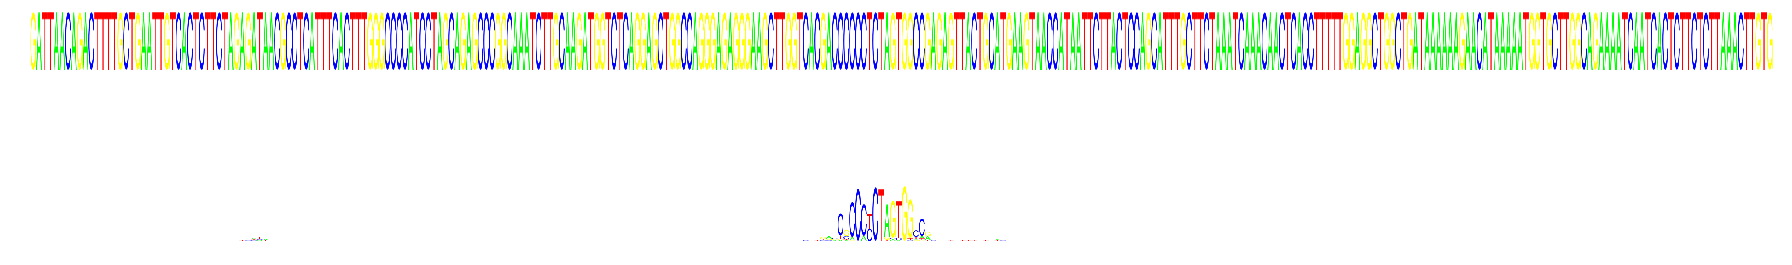

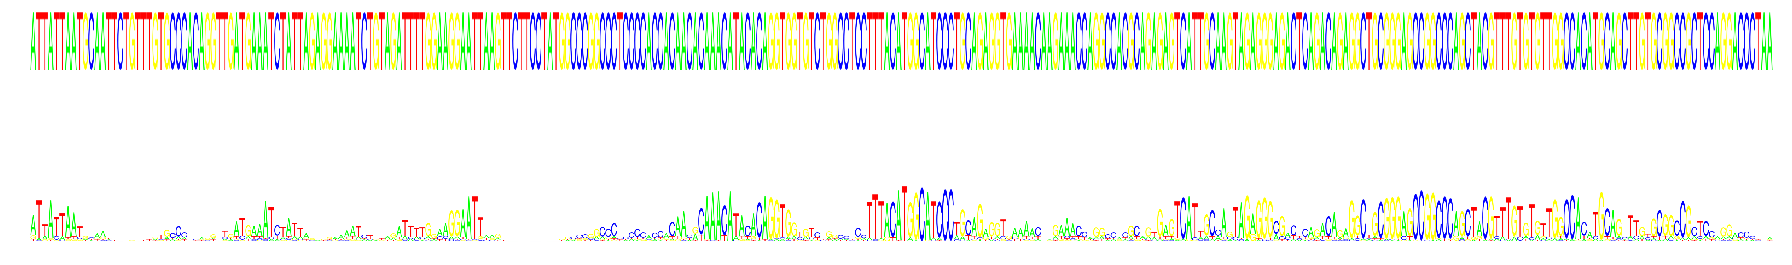

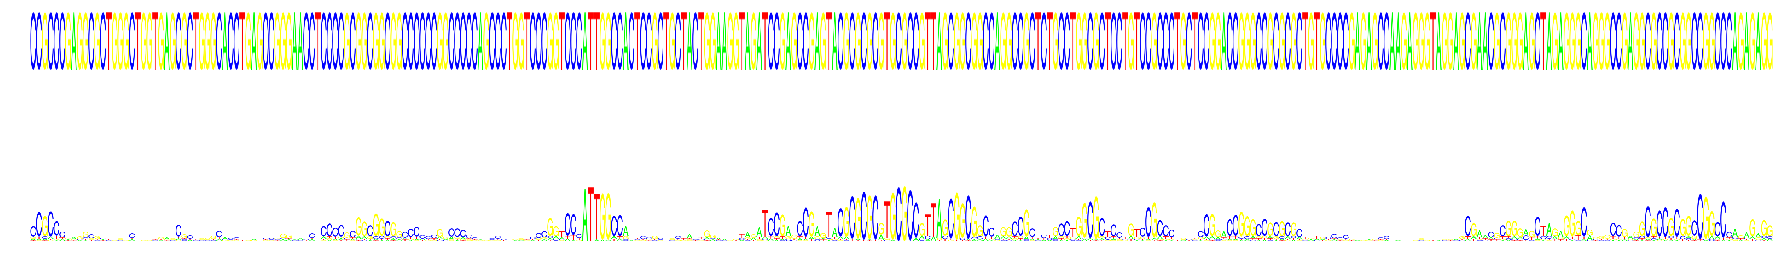

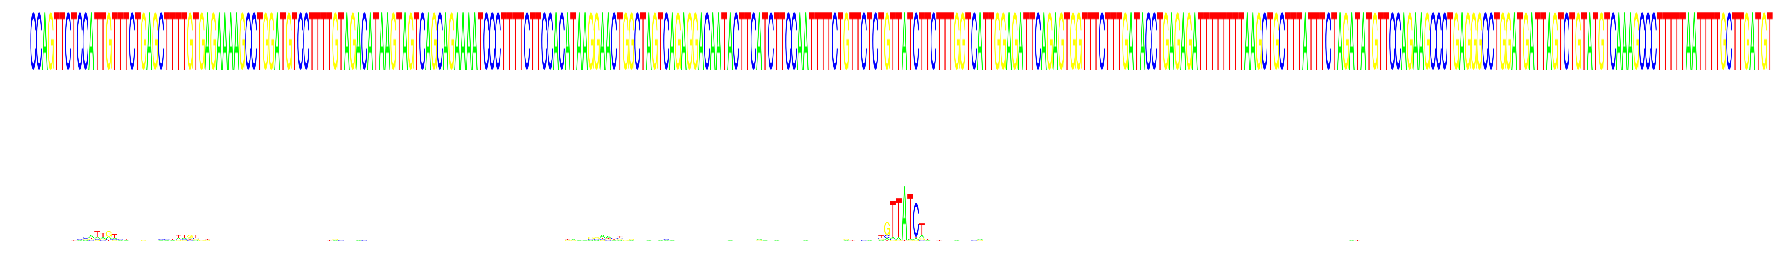

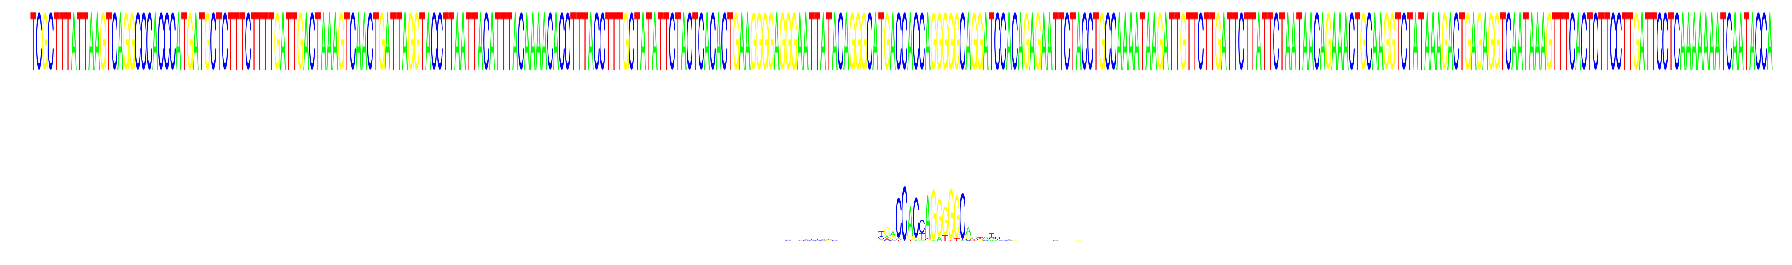

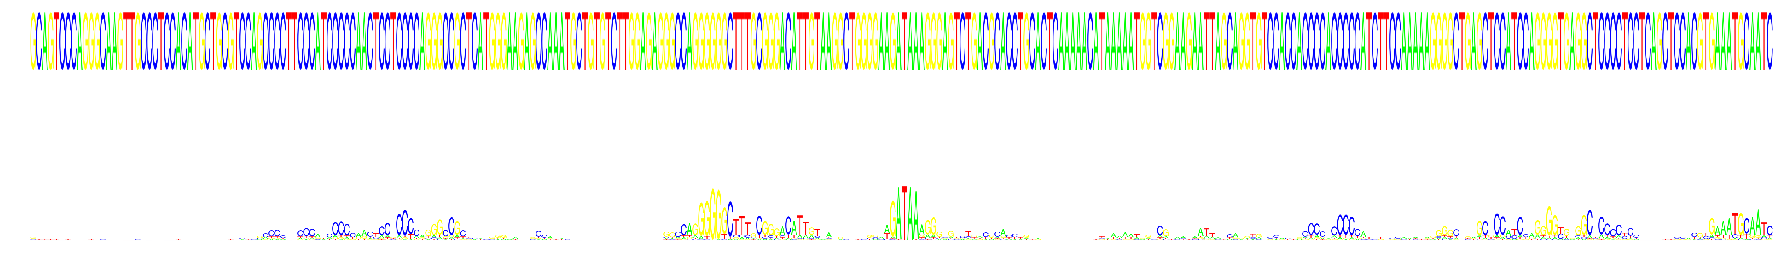

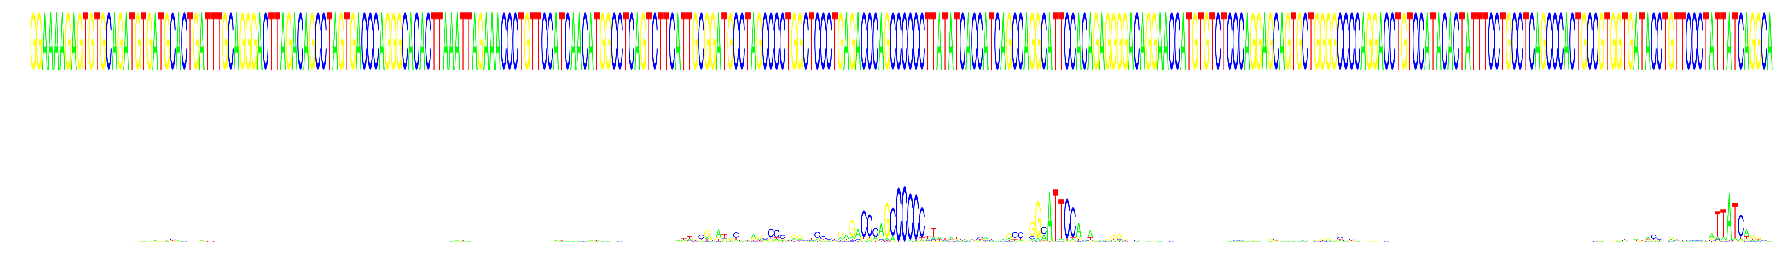

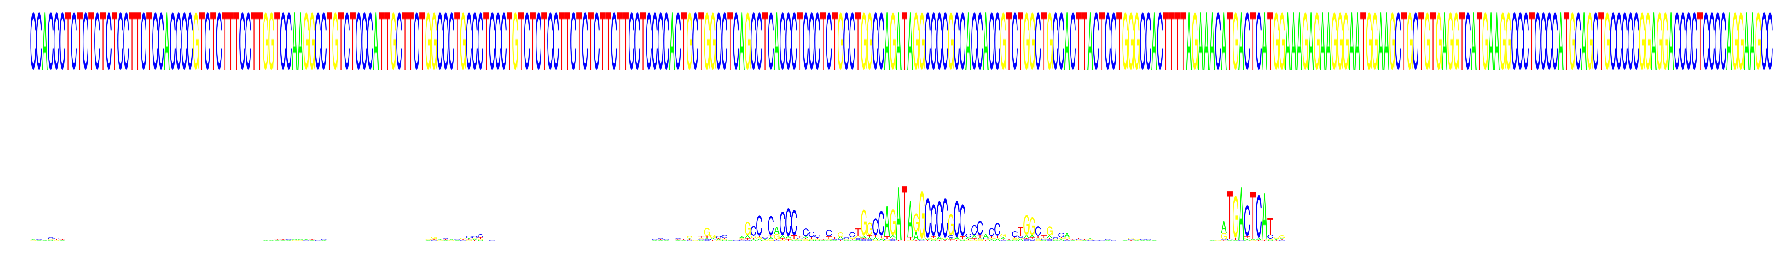

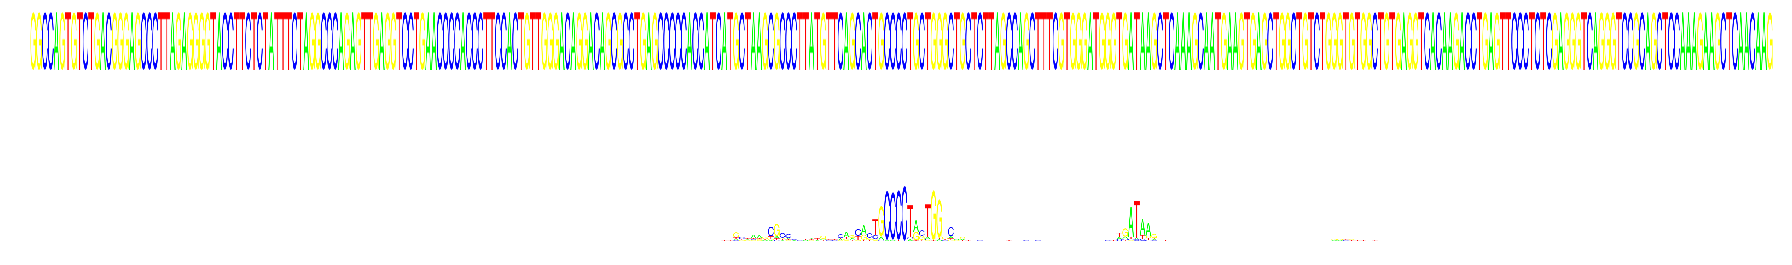

In [29]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,5]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


# MCF-7

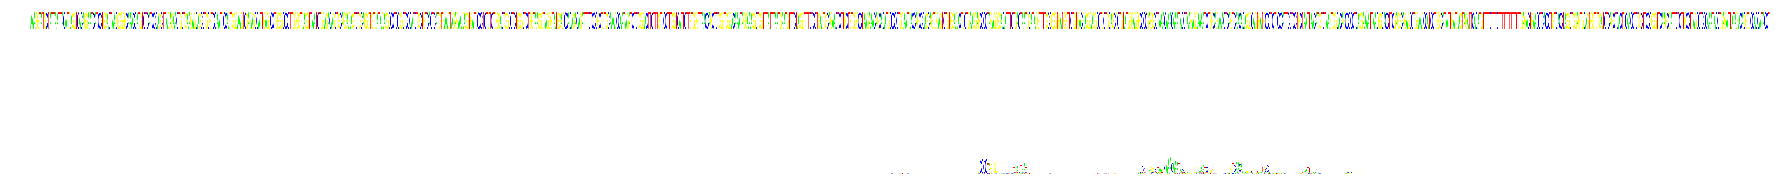

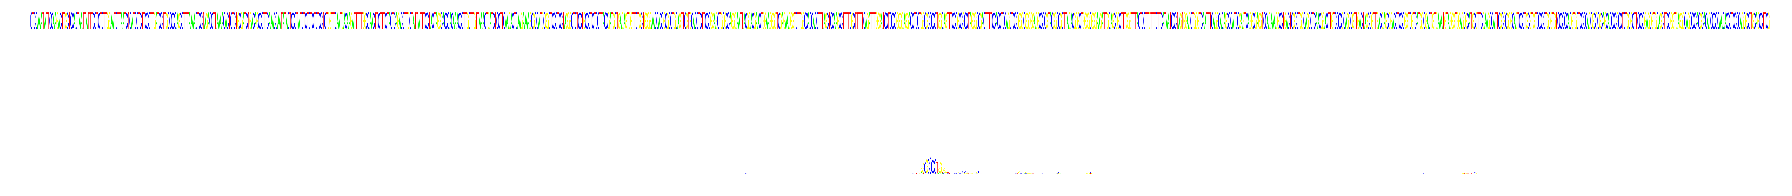

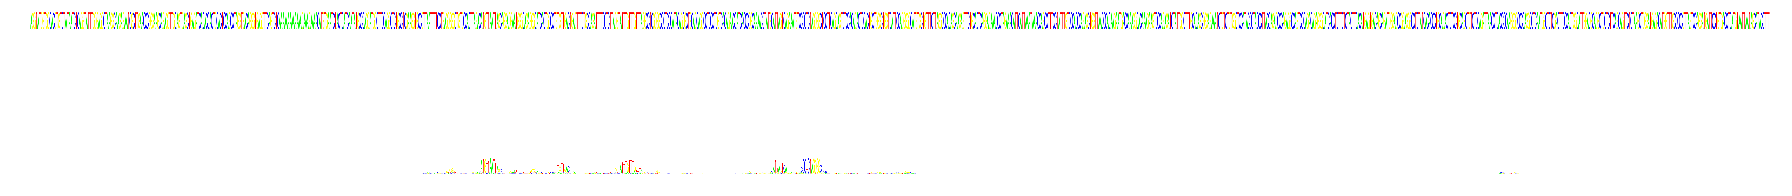

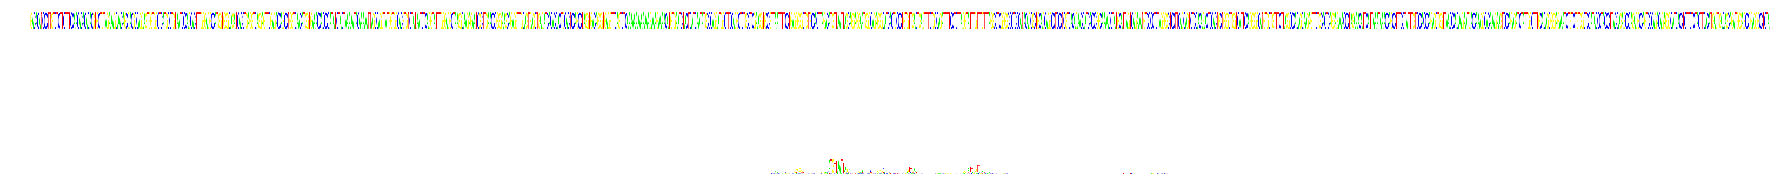

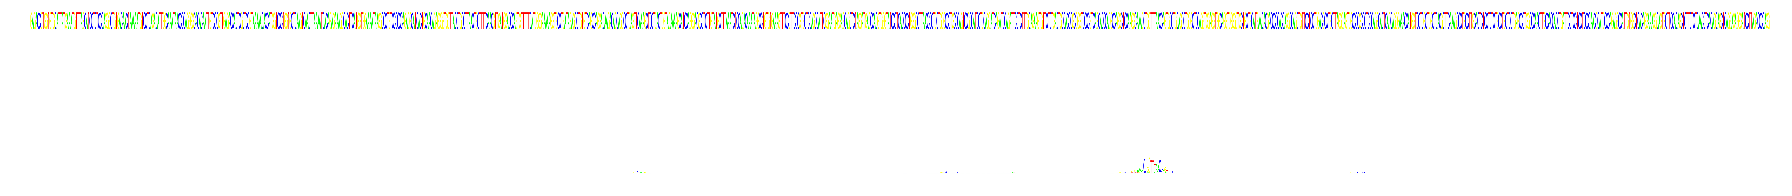

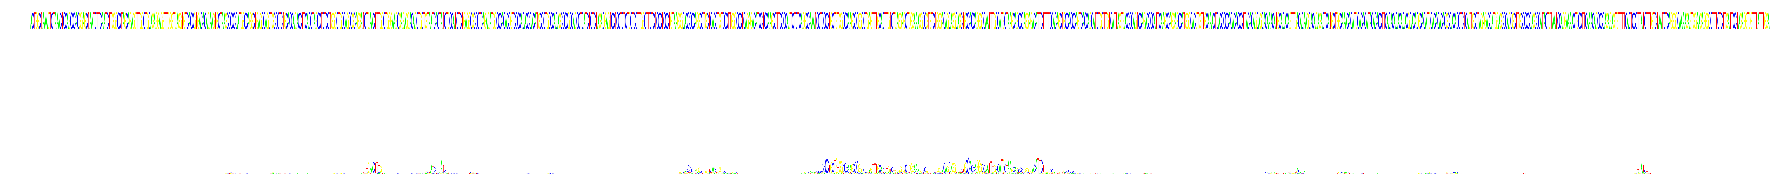

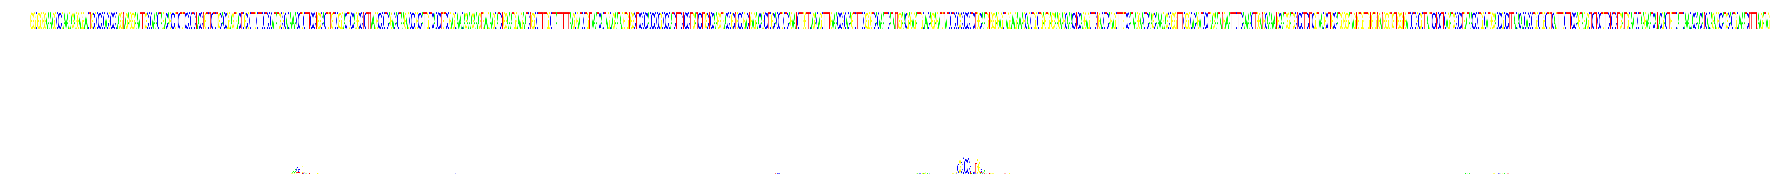

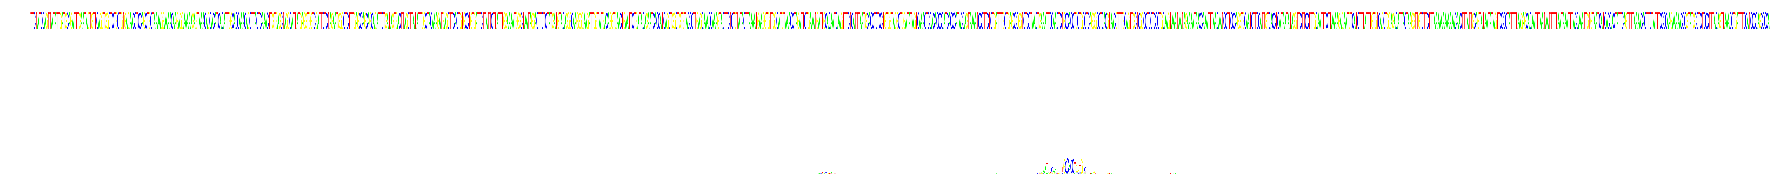

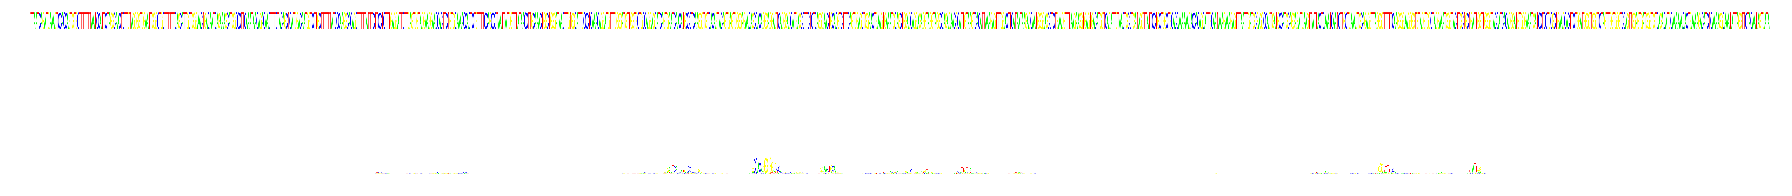

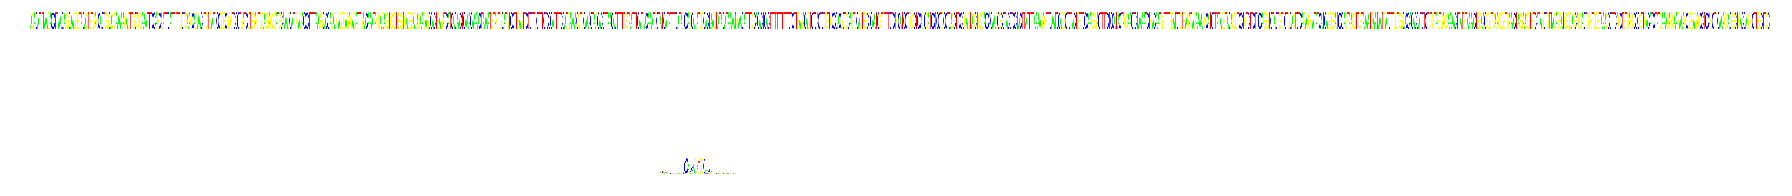

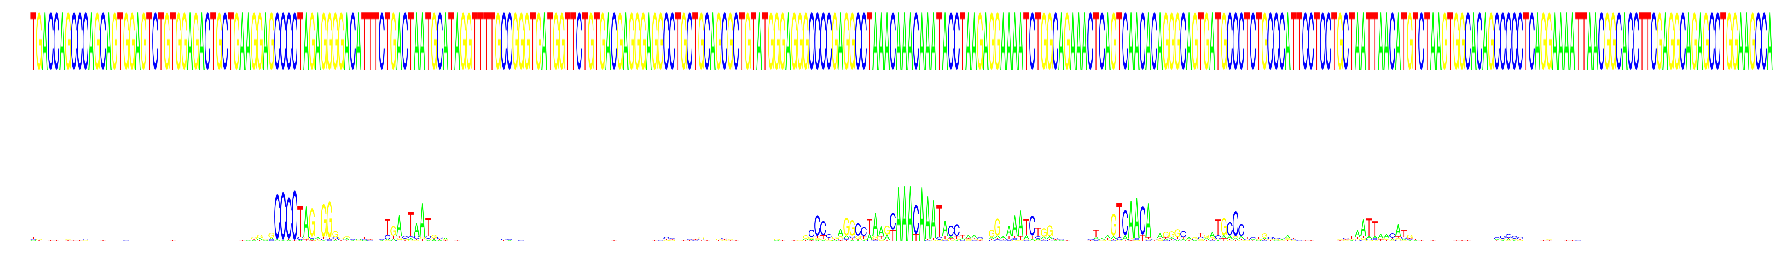

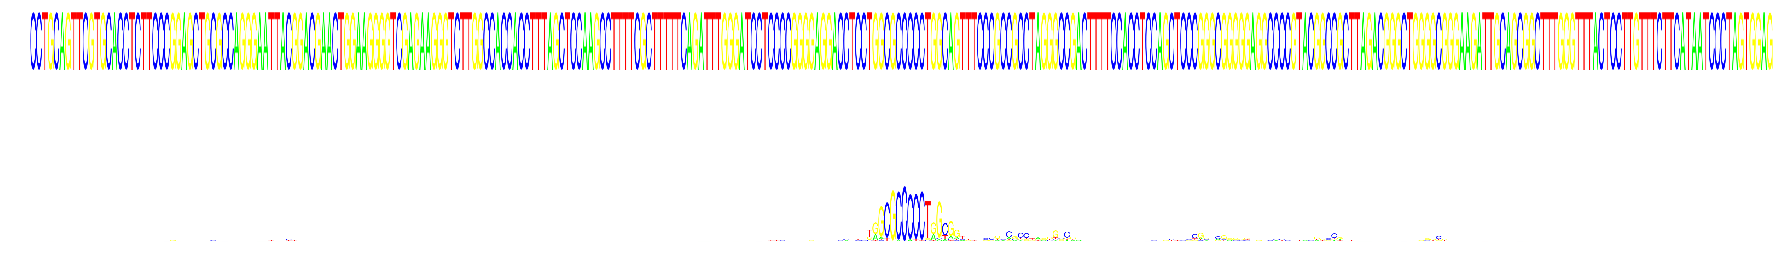

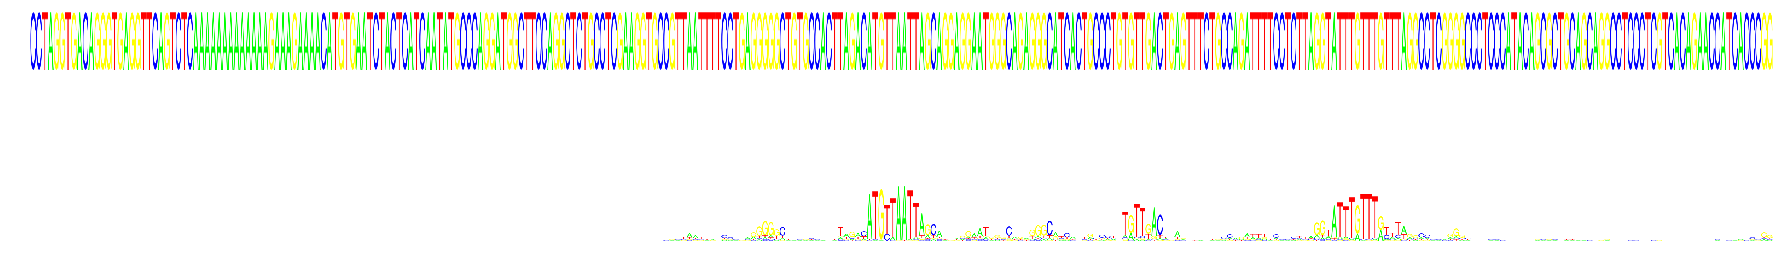

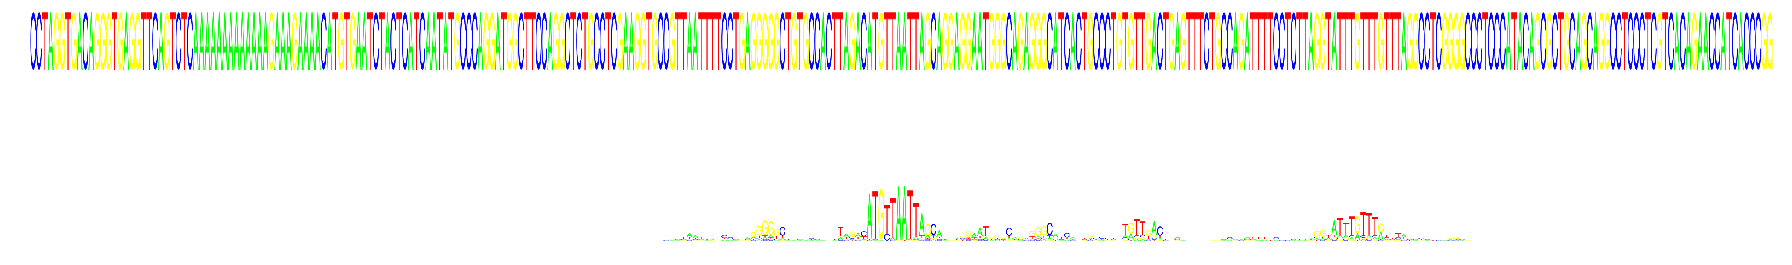

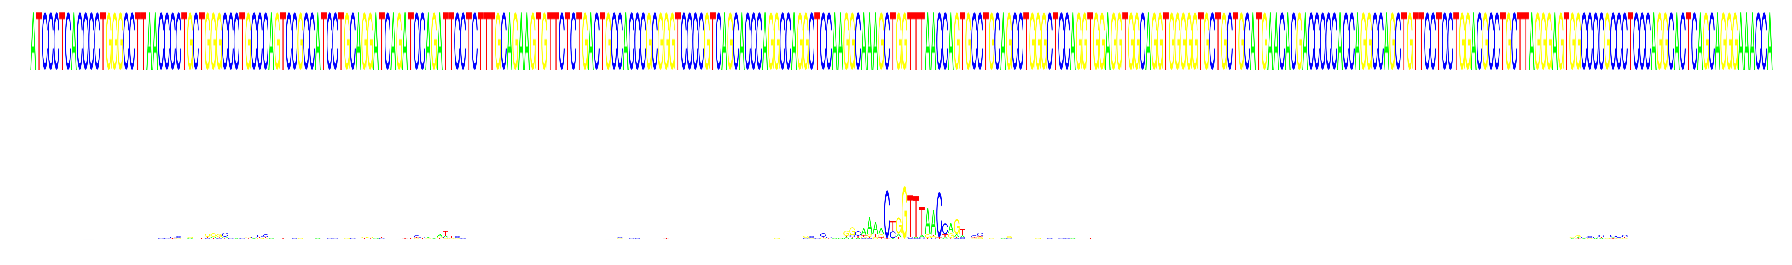

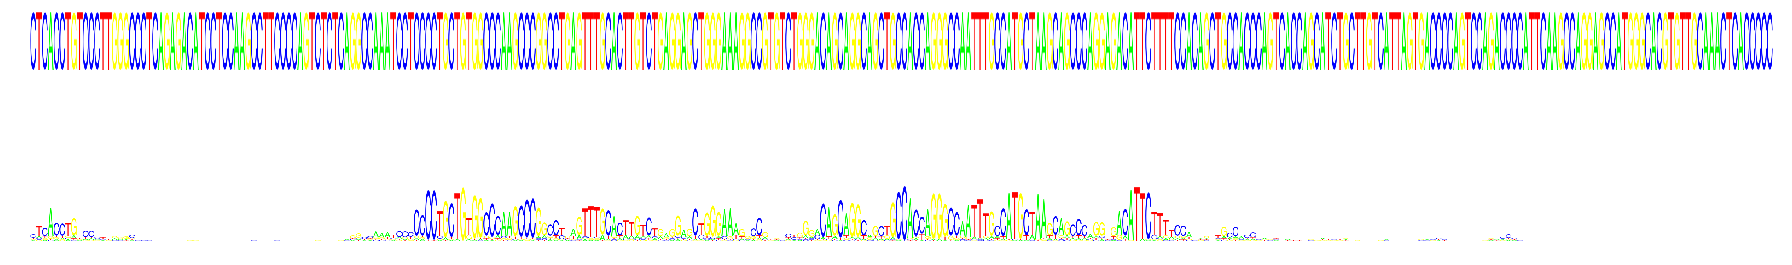

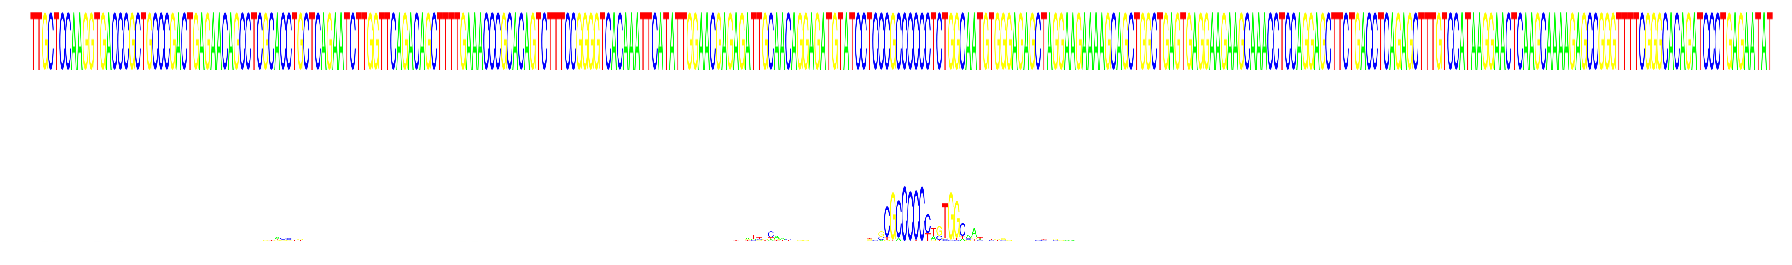

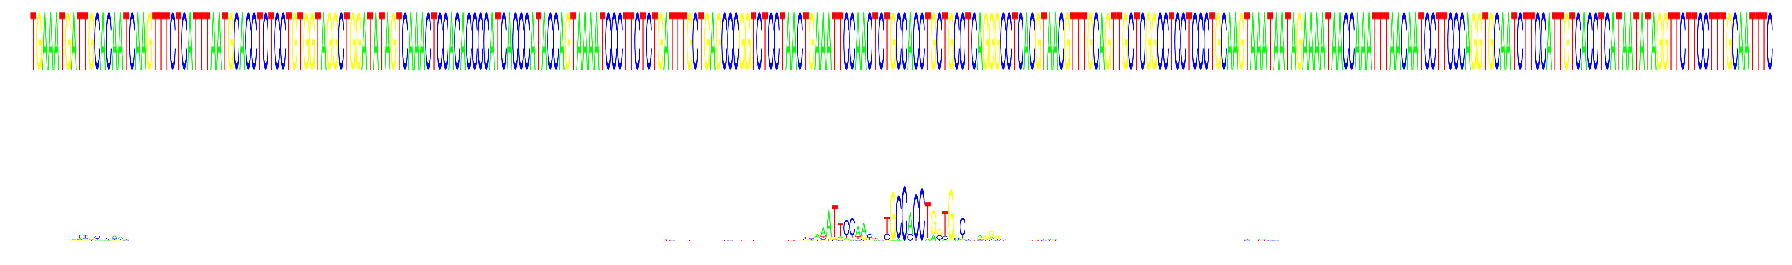

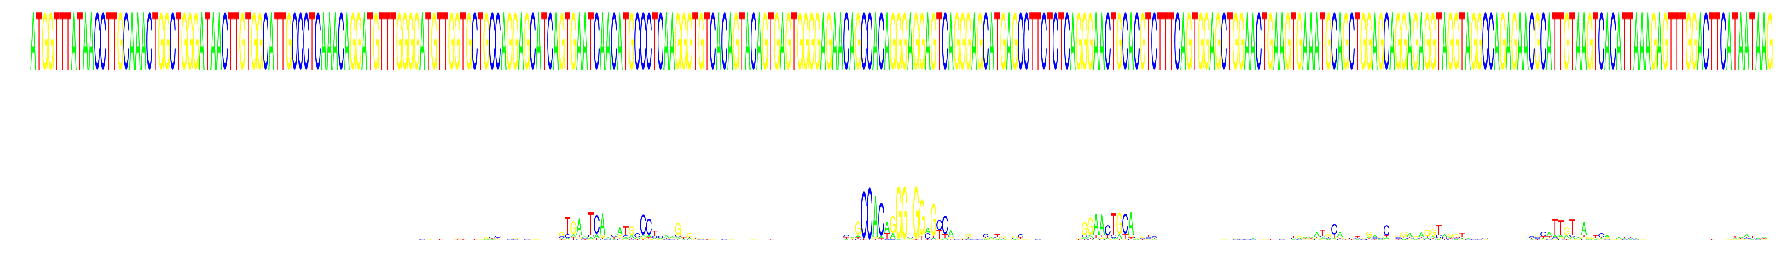

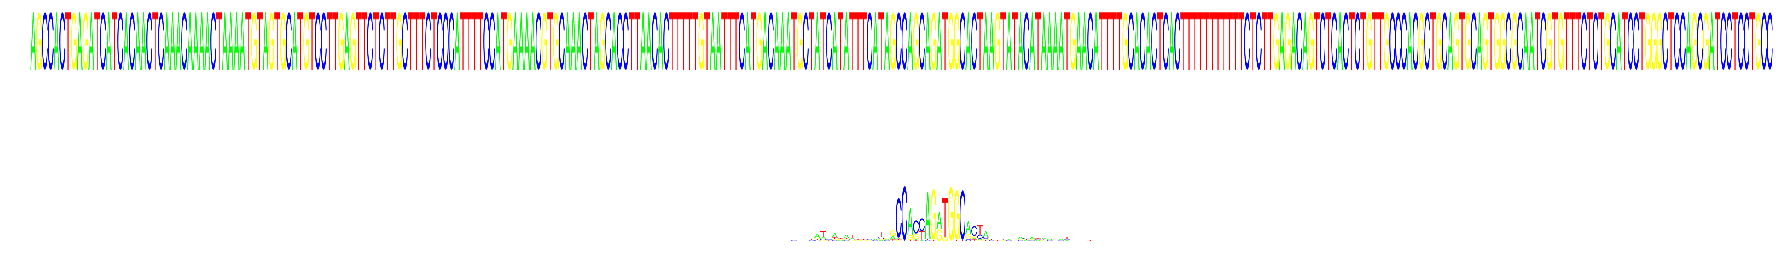

In [30]:

def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm

get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['conv5_active'], deterministic=True), allow_input_downcast=True)
prediction = np.squeeze(get_prediction(test[0]))
predicted_class = np.argmax(prediction,axis=1)

unique_index = np.where((test[1][:,6]==1) & (np.sum(test[1],axis=1)==1))[0]
class_index = unique_index[(np.where(predicted_class[unique_index]==2))[0]]
class_index = class_index[np.argsort(predicted_class[class_index])]


height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = range(1000)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    
    
height=100
bp_width=20
size = (25.,10.0)
for map_index in class_index[:10]:
    X = test[0][map_index]
    X = np.expand_dims(X,0).astype(np.float32)

    saliency, max_class = saliency_fn(X)
    pwm2 = np.copy(np.squeeze(saliency[0]))
    pwm2=normalize_pwm2(pwm2)
    index = np.argmax(np.std(pwm2,axis=0))
    index = range(index-150,index+150)
    pwm2 = pwm2[:,index]
    
    
    logo = seq_logo(np.squeeze(X[0])[:,index], height, bp_width, norm=0, rna=0, filepath='.')
    fig = plt.figure(figsize=size);
    plt.subplot(2,1,1)
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    plt.subplot(2,1,2)
    logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
